# AMME Group LFP Analyses

<p>
This notebook contains for running group level analyses across the AMME dataset.
</p>

---
> Author:    Martina Hollearn   
> Contact:   martina.hollearn@psych.utah.edu   
> Version:   05/22/24      

## 0. Import Libraries

In [1]:
import os
import mne
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_1samp
from datetime import datetime
from collections import defaultdict
from statsmodels.stats.anova import AnovaRM
from statsmodels.formula.api import mixedlm
from scipy.stats import ttest_rel, ttest_ind

%matplotlib inline
%config InlineBackend.figure_format='retina'

## 1. Load & Organize Data
Load and combine the `thetaContrastDF.csv` files generated by `AMME_perSubject_LFP_Analyses.ipynb`.

In [2]:
# Define basic file paths
project_path = '/Users/martinahollearn/Library/CloudStorage/Box-Box/InmanLab/AMME_Data_Emory/AMME_Data'
groupdata_path = os.path.join(project_path, 'LFP_analyses')
group_results_path = os.path.join(project_path, 'LFP_analyses','Group_analyses')
freqs = np.load(os.path.join(project_path, 'Frequency.npy'))

'''
# Define subjects
subjects = ['amyg003', 'amyg005', 'amyg007', 'amyg008', 'amyg009', 'amyg010','amyg011', 'amyg013', 'amyg014', 'amyg016', 'amyg017',
            'amyg030', 'amyg033', 'amyg034', 'amyg037',
            'amyg045', 'amyg046', 'amyg048', 'amyg054', 'amyg057', 'amyg059', 'amyg060', 'amyg061', 'amyg066', 'amyg072']
ROIs = [
    'Hipp', 
    'BLA', 
    # 'PRC', 
    # 'EC', 
    # 'PHG', 
    # 'MTL',
]'
'''

# Define subjects
subjects = ['amyg003', 'amyg008', 'amyg010', 'amyg013', 'amyg017']
ROIs = ['Hipp', 'BLA', 'PRC']


In [3]:
# Read in each subjects AvgStim and NS power for each ROI

group_ns_power = defaultdict(dict)
group_avg_power = defaultdict(dict)
group_onestim_power = defaultdict(dict)
group_threestim_power = defaultdict(dict)
group_beforestim_power = defaultdict(dict)
group_duringstim_power = defaultdict(dict)
group_afterstim_power = defaultdict(dict)

for subject in subjects:
    datapath = os.path.join(project_path, subject)
    preproDataPath = os.path.join(datapath, 'PreprocessedData','Joes_preprocessing')

    for roi in ROIs:
        # Check if the ROI power for avg exists 
        #roi_avg_filename = f'ROI_{roi}_AvgStim_power_remembered.npy'
        roi_avg_filename = f'ROI_{roi}_AvgStim_power_remembered.npy'
        if not os.path.isfile(os.path.join(preproDataPath, roi_avg_filename)):
            print(f"WARNING: Subject {subject} is missing {roi} AvgStim_Power file, expected here: {os.path.join(preproDataPath, roi_avg_filename)}")
            continue
        subj_avg_power = np.load(os.path.join(preproDataPath, roi_avg_filename))

        roi_ns_filename = f'ROI_{roi}_NS_power_remembered.npy'
        if not os.path.isfile(os.path.join(preproDataPath, roi_ns_filename)):
            print(f"WARNING: Subject {subject} is missing {roi} NS_Power file, expected here: {os.path.join(preproDataPath, roi_ns_filename)}")
            continue
        subj_ns_power = np.load(os.path.join(preproDataPath, roi_ns_filename))

        print(f"Subject: {subject} | {roi} Found NS and AVG power data!")
        group_ns_power[roi][subject] = subj_ns_power
        group_avg_power[roi][subject] = subj_avg_power
'''
            #### READING IN DURATION DATA ####
        roi_onestim_filename = f'ROI_{roi}_OneStim_power.npy'
        if not os.path.isfile(os.path.join(preproDataPath, roi_onestim_filename)):
            print(f"WARNING: Subject {subject} is missing {roi} OneStim_Power file, expected here: {os.path.join(preproDataPath, roi_onestim_filename)}")
        else: 
            subj_onestim_power = np.load(os.path.join(preproDataPath, roi_onestim_filename))
            group_onestim_power[roi][subject] = subj_onestim_power

        roi_threestim_filename = f'ROI_{roi}_ThreeStim_power.npy'
        if not os.path.isfile(os.path.join(preproDataPath, roi_threestim_filename)):
            print(f"WARNING: Subject {subject} is missing {roi} ThreeStim_Power file, expected here: {os.path.join(preproDataPath, roi_threestim_filename)}")
        else: 
            subj_threestim_power = np.load(os.path.join(preproDataPath, roi_threestim_filename))
            group_threestim_power[roi][subject] = subj_threestim_power

        #### READING IN TIMING DATA ####
        roi_beforestim_filename = f'ROI_{roi}_BeforeStim_power.npy'
        if not os.path.isfile(os.path.join(preproDataPath, roi_beforestim_filename)):
            print(f"WARNING: Subject {subject} is missing {roi} BeforeStim_Power file, expected here: {os.path.join(preproDataPath, roi_beforestim_filename)}")
        else: 
            subj_beforestim_power = np.load(os.path.join(preproDataPath, roi_beforestim_filename))
            group_beforestim_power[roi][subject] = subj_beforestim_power

        roi_duringstim_filename = f'ROI_{roi}_DuringStim_power.npy'
        if not os.path.isfile(os.path.join(preproDataPath, roi_duringstim_filename)):
            print(f"WARNING: Subject {subject} is missing {roi} DuringStim_Power file, expected here: {os.path.join(preproDataPath, roi_duringstim_filename)}")
        else: 
            subj_duringstim_power = np.load(os.path.join(preproDataPath, roi_duringstim_filename))
            group_duringstim_power[roi][subject] = subj_duringstim_power

        roi_afterstim_filename = f'ROI_{roi}_AfterStim_power.npy'
        if not os.path.isfile(os.path.join(preproDataPath, roi_afterstim_filename)):
            print(f"WARNING: Subject {subject} is missing {roi} AfterStim_Power file, expected here: {os.path.join(preproDataPath, roi_afterstim_filename)}")
        else: 
            subj_afterstim_power = np.load(os.path.join(preproDataPath, roi_afterstim_filename))
            group_afterstim_power[roi][subject] = subj_afterstim_power

        print(f"Subject: {subject} | {roi} Found NS and AVG power data!")
        group_ns_power[roi][subject] = subj_ns_power
        group_avg_power[roi][subject] = subj_avg_power
'''

Subject: amyg003 | Hipp Found NS and AVG power data!
Subject: amyg003 | BLA Found NS and AVG power data!
Subject: amyg003 | PRC Found NS and AVG power data!
Subject: amyg008 | Hipp Found NS and AVG power data!
Subject: amyg008 | BLA Found NS and AVG power data!
Subject: amyg008 | PRC Found NS and AVG power data!
Subject: amyg010 | Hipp Found NS and AVG power data!
Subject: amyg010 | BLA Found NS and AVG power data!
Subject: amyg010 | PRC Found NS and AVG power data!
Subject: amyg013 | Hipp Found NS and AVG power data!
Subject: amyg013 | BLA Found NS and AVG power data!
Subject: amyg013 | PRC Found NS and AVG power data!
Subject: amyg017 | Hipp Found NS and AVG power data!
Subject: amyg017 | BLA Found NS and AVG power data!
Subject: amyg017 | PRC Found NS and AVG power data!


'\n            #### READING IN DURATION DATA ####\n        roi_onestim_filename = f\'ROI_{roi}_OneStim_power.npy\'\n        if not os.path.isfile(os.path.join(preproDataPath, roi_onestim_filename)):\n            print(f"WARNING: Subject {subject} is missing {roi} OneStim_Power file, expected here: {os.path.join(preproDataPath, roi_onestim_filename)}")\n        else: \n            subj_onestim_power = np.load(os.path.join(preproDataPath, roi_onestim_filename))\n            group_onestim_power[roi][subject] = subj_onestim_power\n\n        roi_threestim_filename = f\'ROI_{roi}_ThreeStim_power.npy\'\n        if not os.path.isfile(os.path.join(preproDataPath, roi_threestim_filename)):\n            print(f"WARNING: Subject {subject} is missing {roi} ThreeStim_Power file, expected here: {os.path.join(preproDataPath, roi_threestim_filename)}")\n        else: \n            subj_threestim_power = np.load(os.path.join(preproDataPath, roi_threestim_filename))\n            group_threestim_power[roi

In [4]:
for subj, subj_dict in group_avg_power.items():
    for roi, roi_data in subj_dict.items():
        print(f"Subject: {subj} | ROI: {roi} | Data Shape: {roi_data.shape}")

Subject: Hipp | ROI: amyg003 | Data Shape: (60,)
Subject: Hipp | ROI: amyg008 | Data Shape: (60,)
Subject: Hipp | ROI: amyg010 | Data Shape: (60,)
Subject: Hipp | ROI: amyg013 | Data Shape: (60,)
Subject: Hipp | ROI: amyg017 | Data Shape: (60,)
Subject: BLA | ROI: amyg003 | Data Shape: (60,)
Subject: BLA | ROI: amyg008 | Data Shape: (60,)
Subject: BLA | ROI: amyg010 | Data Shape: (60,)
Subject: BLA | ROI: amyg013 | Data Shape: (60,)
Subject: BLA | ROI: amyg017 | Data Shape: (60,)
Subject: PRC | ROI: amyg003 | Data Shape: (60,)
Subject: PRC | ROI: amyg008 | Data Shape: (60,)
Subject: PRC | ROI: amyg010 | Data Shape: (60,)
Subject: PRC | ROI: amyg013 | Data Shape: (60,)
Subject: PRC | ROI: amyg017 | Data Shape: (60,)


Running ROI: Hipp
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Running ROI: BLA
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Running ROI: PRC
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)


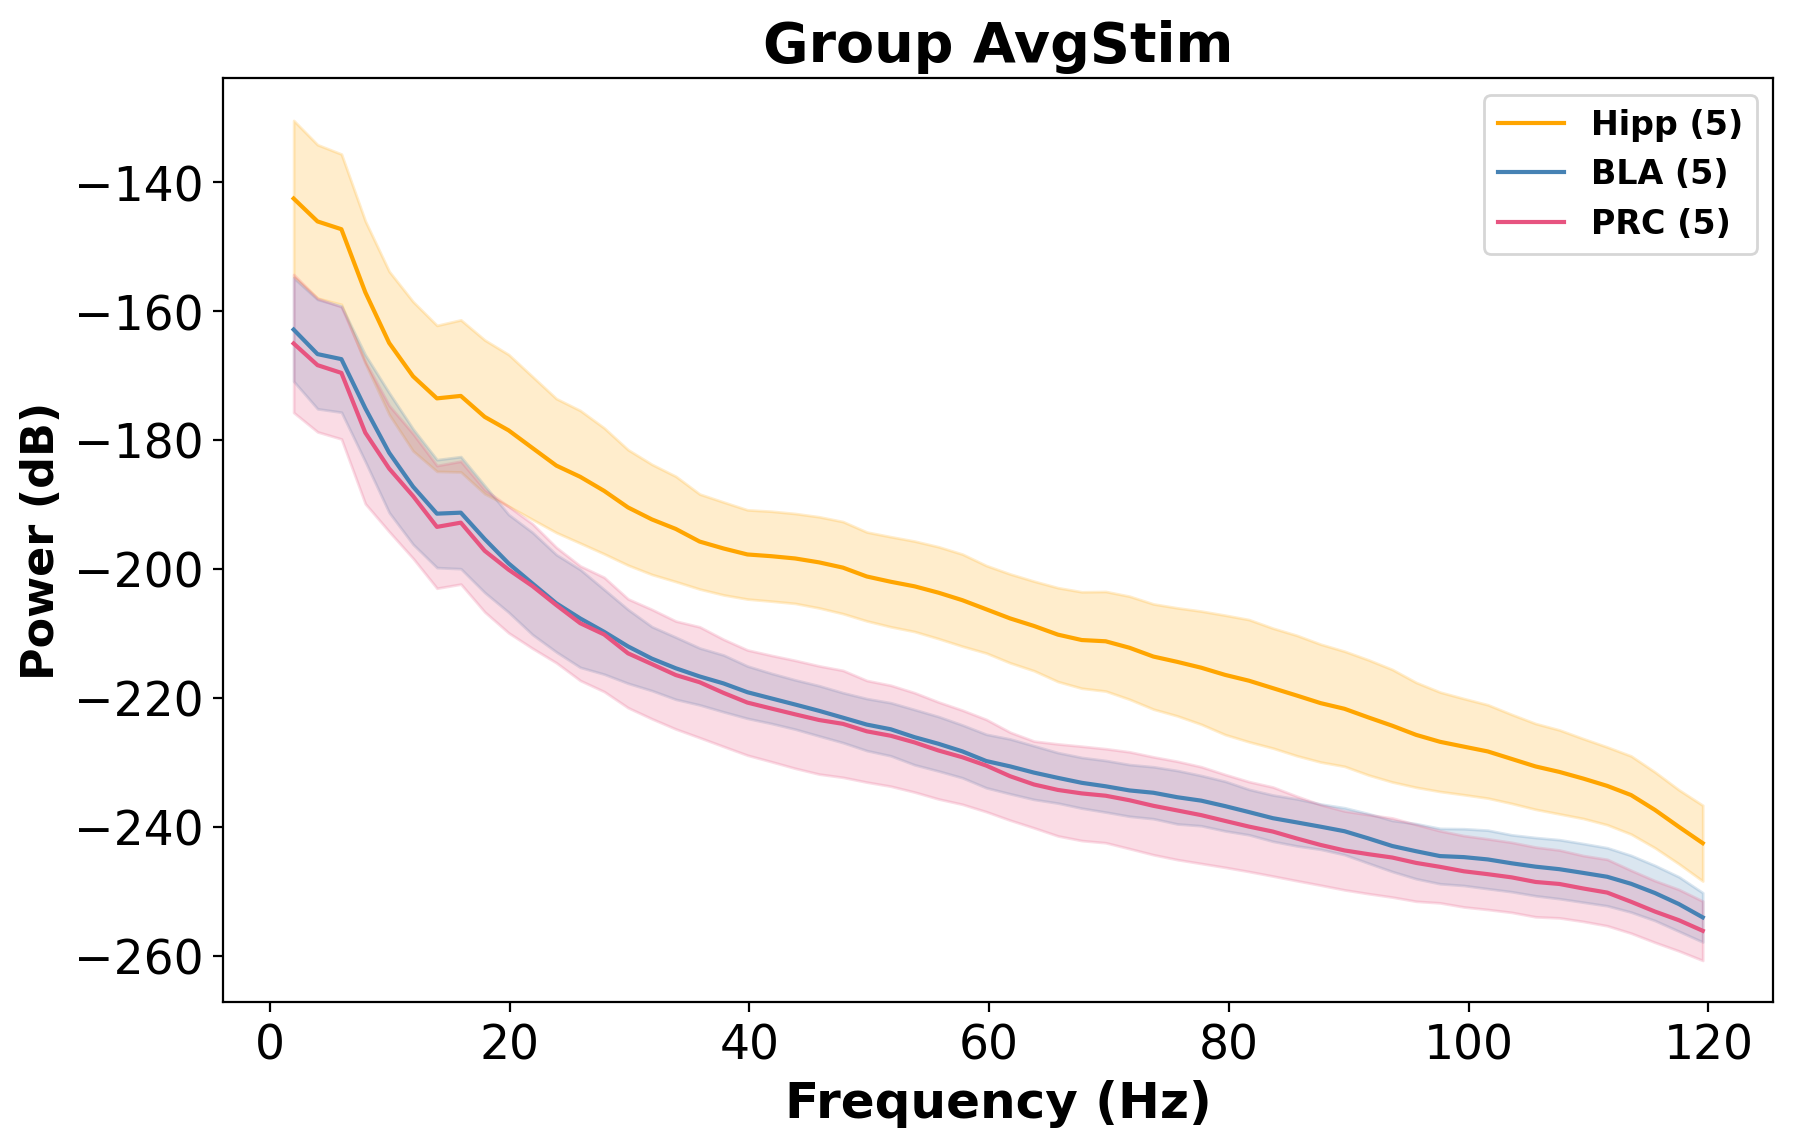

Running ROI: Hipp
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Running ROI: BLA
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Running ROI: PRC
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)


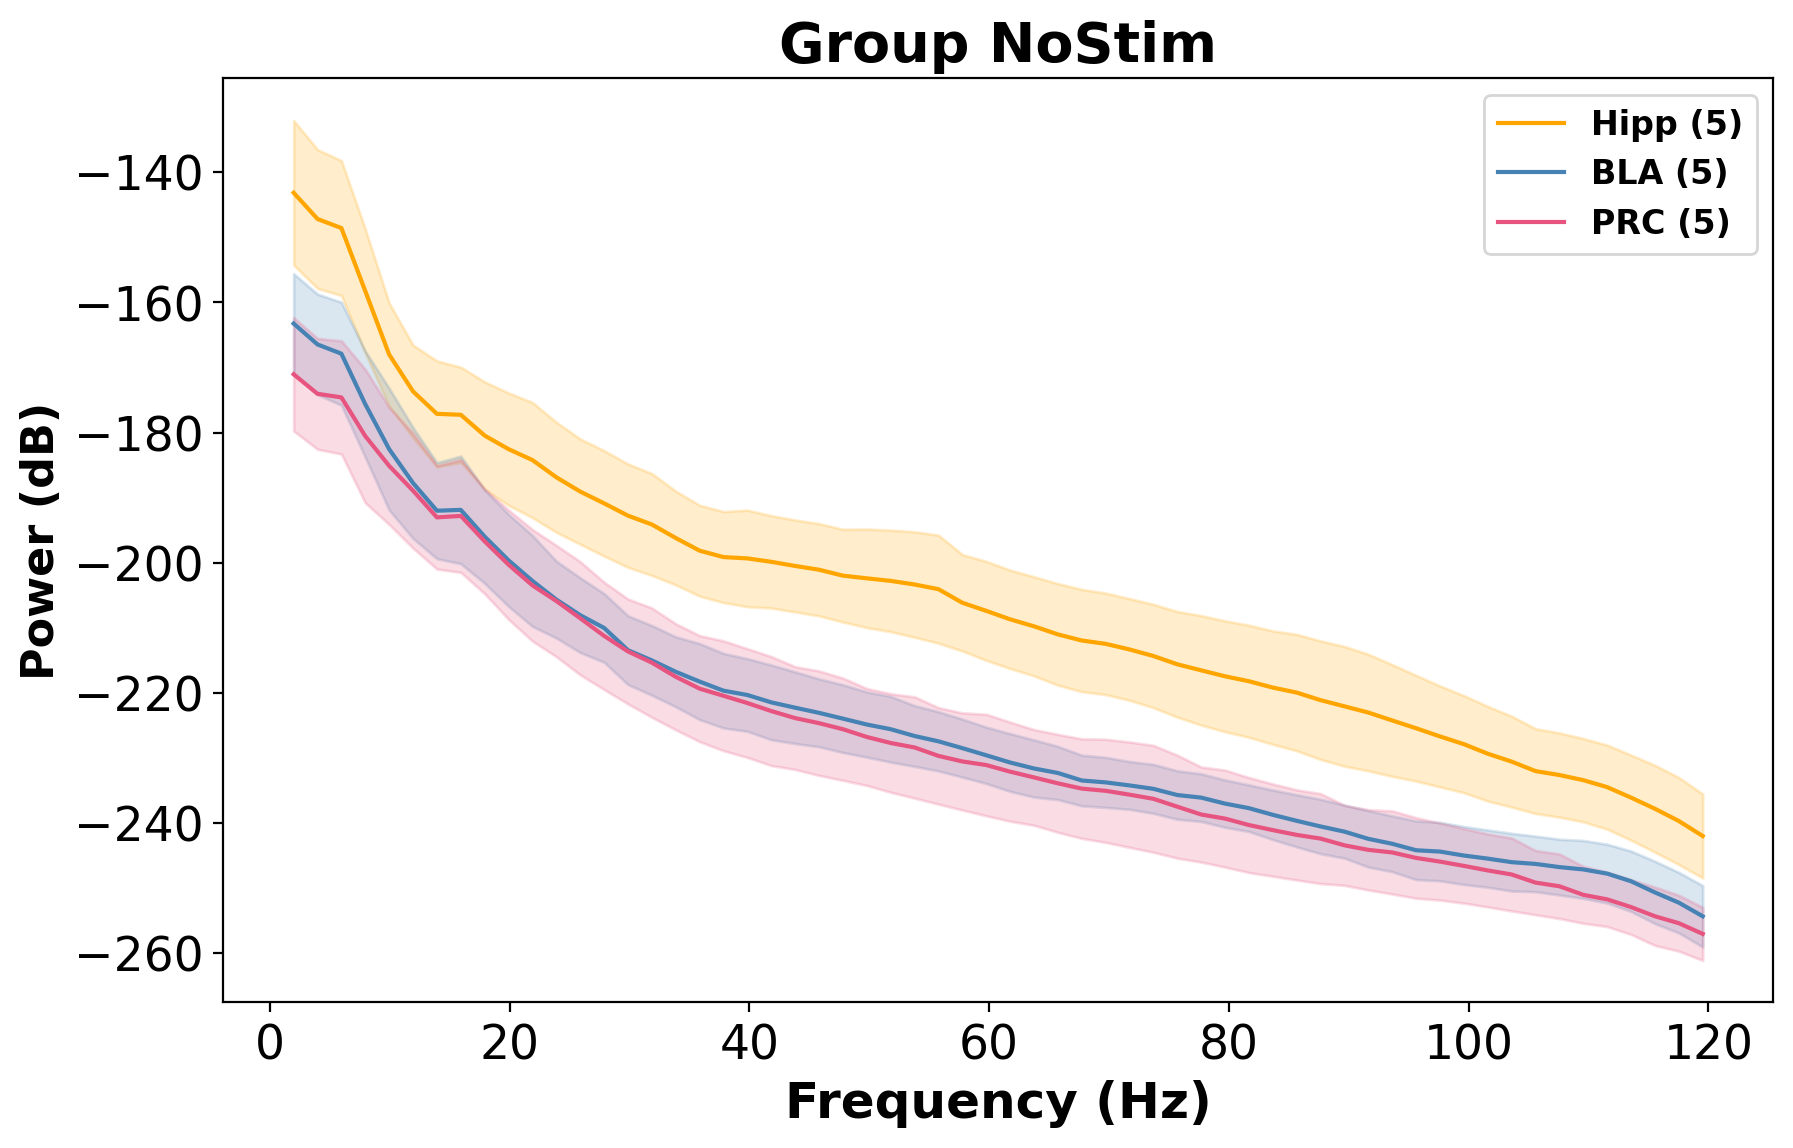

In [5]:
# Plot Each ROI as a group average
conditions = {
    'AvgStim': group_avg_power,
    'NoStim': group_ns_power,
}

for stim_condition, power_data in conditions.items():
    plt.figure(figsize=(10, 6))
    for roi in ROIs:
        print(f"Running ROI: {roi}")
        # Check the shapes of the data for each subject in this ROI
        for power in power_data[roi].values():
            print(f"Shape of power data: {np.shape(power)}")
        
        # Assuming they are lists/arrays, try to stack them into a consistent 2D array
        try:
            this_roi_power_data = np.array([power for power in power_data[roi].values()])
        except ValueError as e:
            print(f"Error occurred: {e}")
            continue

        num_subjects = len(power_data[roi].values())

        # Calculate the mean and standard deviation
        mean = np.mean(this_roi_power_data, axis=0)  # Example: average over subjects or trials
        std = np.std(this_roi_power_data, axis=0)
        #x = np.linspace(1, 120, num=len(mean))  # x should match the length of mean

        if roi == 'Hipp':
            color = 'orange'
        elif roi == 'BLA':
            color = '#4682B4'  # dark blue
        elif roi == 'PRC':
            color = '#E75480'  # dark pink
        elif roi == 'EC':
            color = '#8A2BE2' # dark purple
        elif roi == 'PHG':
            color = 'blue'
        elif roi == 'MTL':
            color = 'black'

        # Create the plot
        plt.plot(freqs, mean, label=f'{roi} ({num_subjects})', color=color)
        plt.fill_between(freqs, mean - std, mean + std, alpha=0.2, color=color, label=None)

    # Add labels and legend
    plt.xlabel('Frequency (Hz)', fontsize=18, fontweight='bold')
    plt.ylabel('Power (dB)', fontsize=16, fontweight='bold')
    plt.title(f'Group {stim_condition}', fontsize=20, fontweight='bold')
    plt.legend(prop={'weight': 'bold', 'size': 12})

    # Make x ticks, y ticks bold and larger
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    # Show the plot
    plt.savefig(os.path.join(group_results_path, f'{stim_condition}_Power.png'))
    plt.show()


Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)
Shape of power data: (60,)


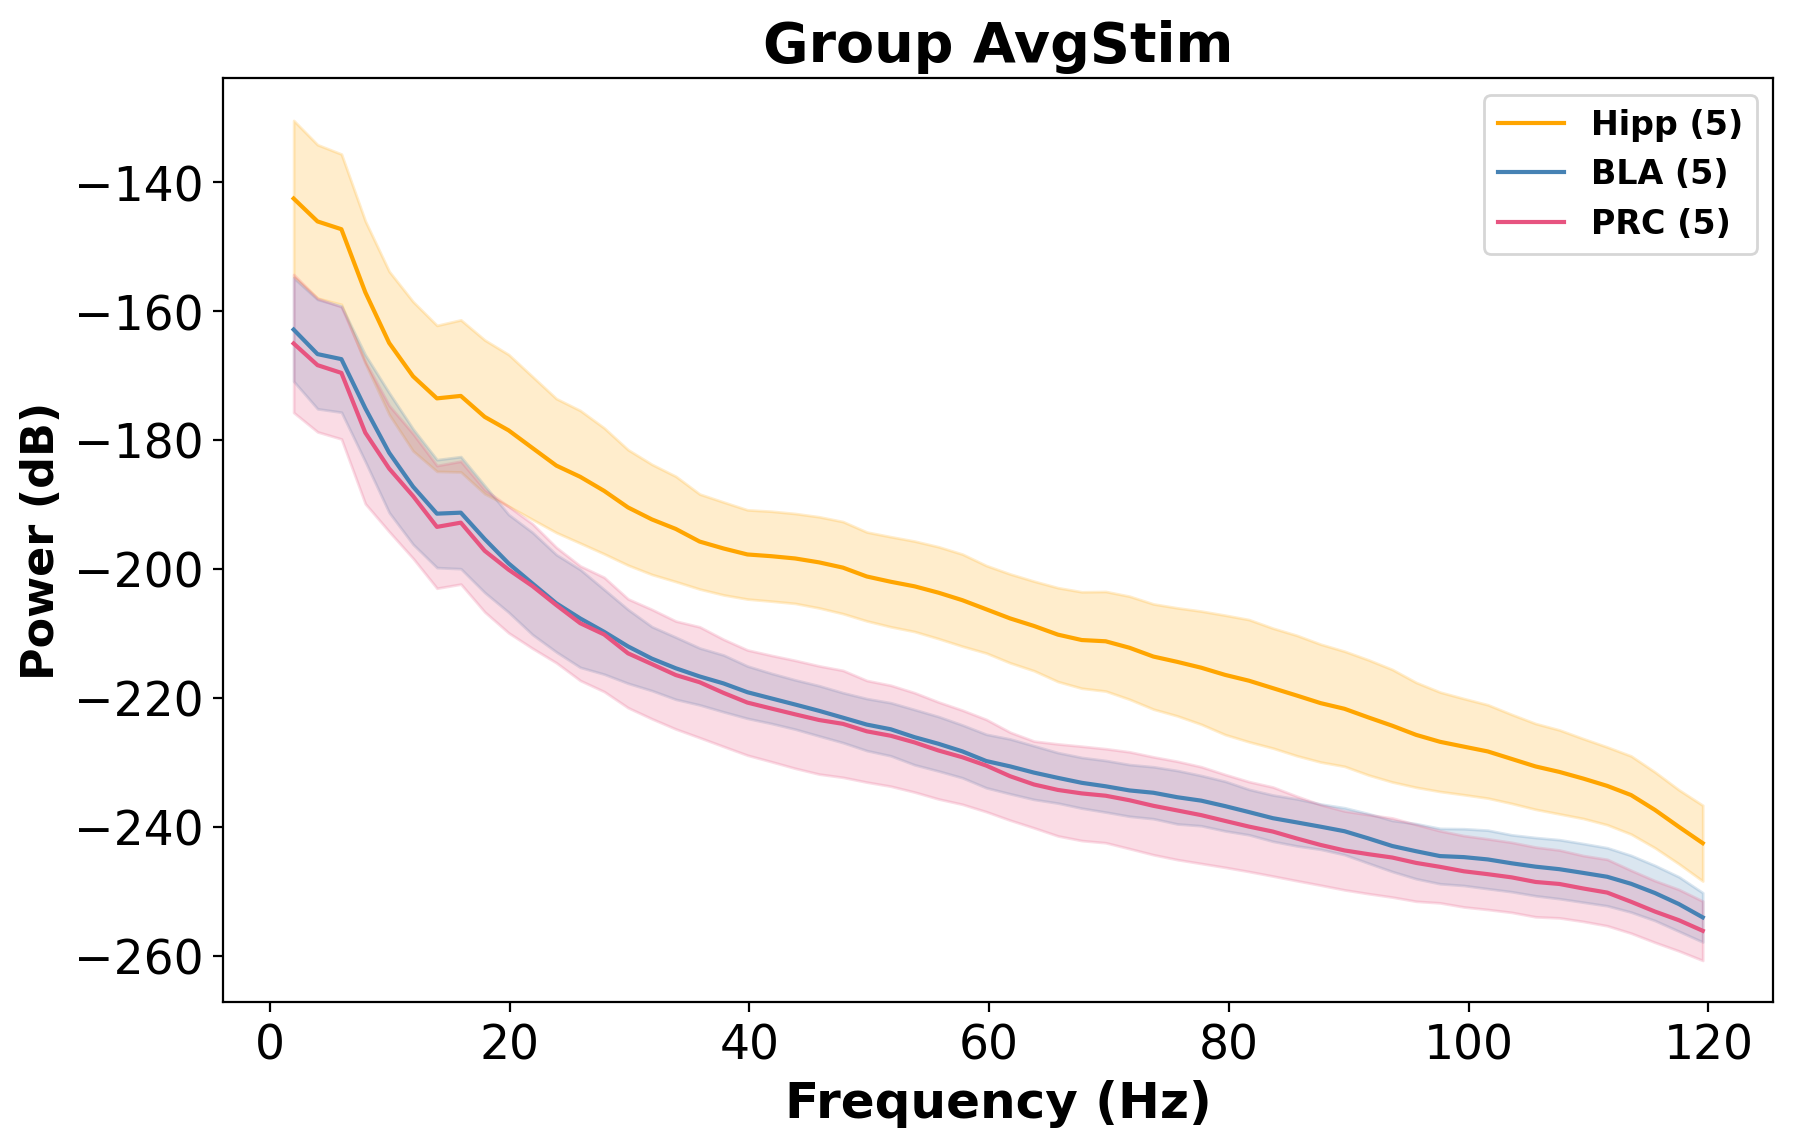

In [6]:
# Plot Each ROI as a group average
conditions = {
    'AvgStim': group_avg_power,
}

for stim_condition, power_data in conditions.items():
    plt.figure(figsize=(10, 6))
    for roi in ROIs:
        # Check the shapes of the data for each subject in this ROI
        for power in power_data[roi].values():
            print(f"Shape of power data: {np.shape(power)}")
        
        # Assuming they are lists/arrays, try to stack them into a consistent 2D array
        try:
            this_roi_power_data = np.array([power for power in power_data[roi].values()])
        except ValueError as e:
            print(f"Error occurred: {e}")
            continue

        num_subjects = len(power_data[roi].values())

        # Calculate the mean and standard deviation
        mean = np.mean(this_roi_power_data, axis=0)
        std = np.std(this_roi_power_data, axis=0)

        # Generate x values based on the length of the mean array
        #x = np.linspace(1, 120, num=len(mean))

        if roi == 'Hipp':
            color = 'orange'
        elif roi == 'BLA':
            color = '#4682B4'  # dark blue
        elif roi == 'PRC':
            color = '#E75480'  # dark pink
        elif roi == 'EC':
            color = '#8A2BE2' # dark purple
        elif roi == 'PHG':
            color = 'blue'
        elif roi == 'MTL':
            color = 'black'

        # Create the plot
        plt.plot(freqs, mean, label=f'{roi} ({num_subjects})', color=color)
        plt.fill_between(freqs, mean - std, mean + std, alpha=0.2, color=color, label=None)

    # Add labels and legend
    plt.xlabel('Frequency (Hz)', fontsize=18, fontweight='bold')
    plt.ylabel('Power (dB)', fontsize=16, fontweight='bold')
    plt.title(f'Group {stim_condition}', fontsize=20, fontweight='bold')
    plt.legend(prop={'weight': 'bold', 'size': 12})

    # Make x ticks, y ticks bold and larger
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    # Show the plot
    plt.savefig(os.path.join(group_results_path, f'{stim_condition}_Power.png'))
    plt.show()


## Subtract no stim from all stim conditions

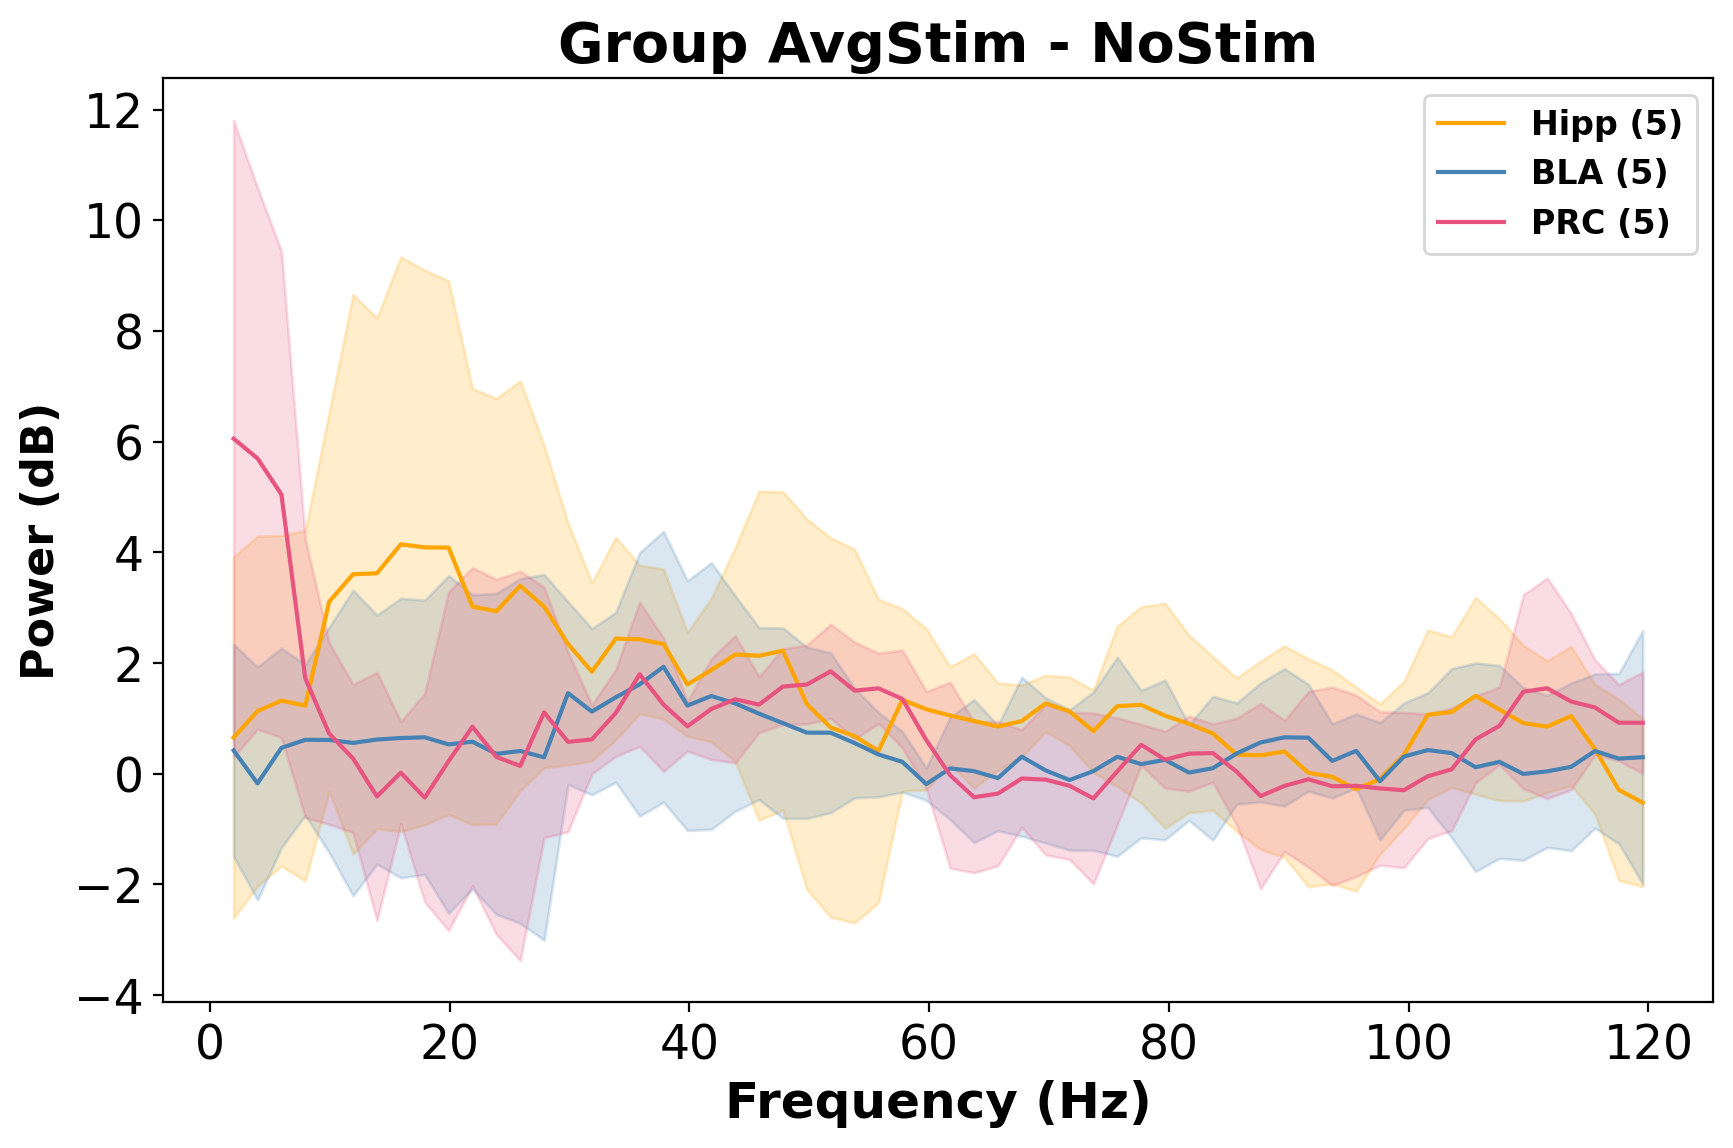

In [7]:
# Plot Each ROI as a group average
conditions = {
    'AvgStim': group_avg_power,
}

for stim_condition, power_data,  in conditions.items():
    plt.figure(figsize=(10, 6))
    for roi in ROIs:
        this_roi_power_data = np.array([power for power in power_data[roi].values()])
        this_ns_roi_power_data = np.array([power for power in group_ns_power[roi].values()])

        diff_roi_power_data = this_roi_power_data - this_ns_roi_power_data

        num_subjects = len(power_data[roi].values())

        # Calculate the mean and standard deviation
        mean = np.mean(diff_roi_power_data, axis=0)
        std = np.std(diff_roi_power_data, axis=0)

        # Generate x values
        x = np.linspace(1, 120, num=len(mean))

        if roi == 'Hipp':
            color = 'orange'
        elif roi == 'BLA':
            color = '#4682B4' # dark blue
        elif roi == 'PRC':
            color = '#E75480' # dark pink
        elif roi == 'EC':
            color = '#8A2BE2' # dark purple
        elif roi == 'PHG':
            color = 'blue'
        elif roi == 'MTL':
            color = 'black'
    
        # Create the plot
        plt.plot(freqs, mean, label=f'{roi} ({num_subjects})', color = color)
        plt.fill_between(freqs, mean - std, mean + std, alpha=0.2, color = color, label=None)

    # Add labels and legend
    plt.xlabel('Frequency (Hz)',fontsize=18, fontweight='bold')
    plt.ylabel('Power (dB)',fontsize=16, fontweight='bold')
    plt.title(f'Group {stim_condition} - NoStim', fontsize=20, fontweight='bold')
    plt.legend(prop={'weight': 'bold', 'size': 12})

    # Make x ticks, y ticks bold and larger
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    # Show the plot
    plt.savefig(os.path.join(group_results_path, f'{stim_condition}_Diff_Avg_vs_NS_Power.png'))
    plt.show()


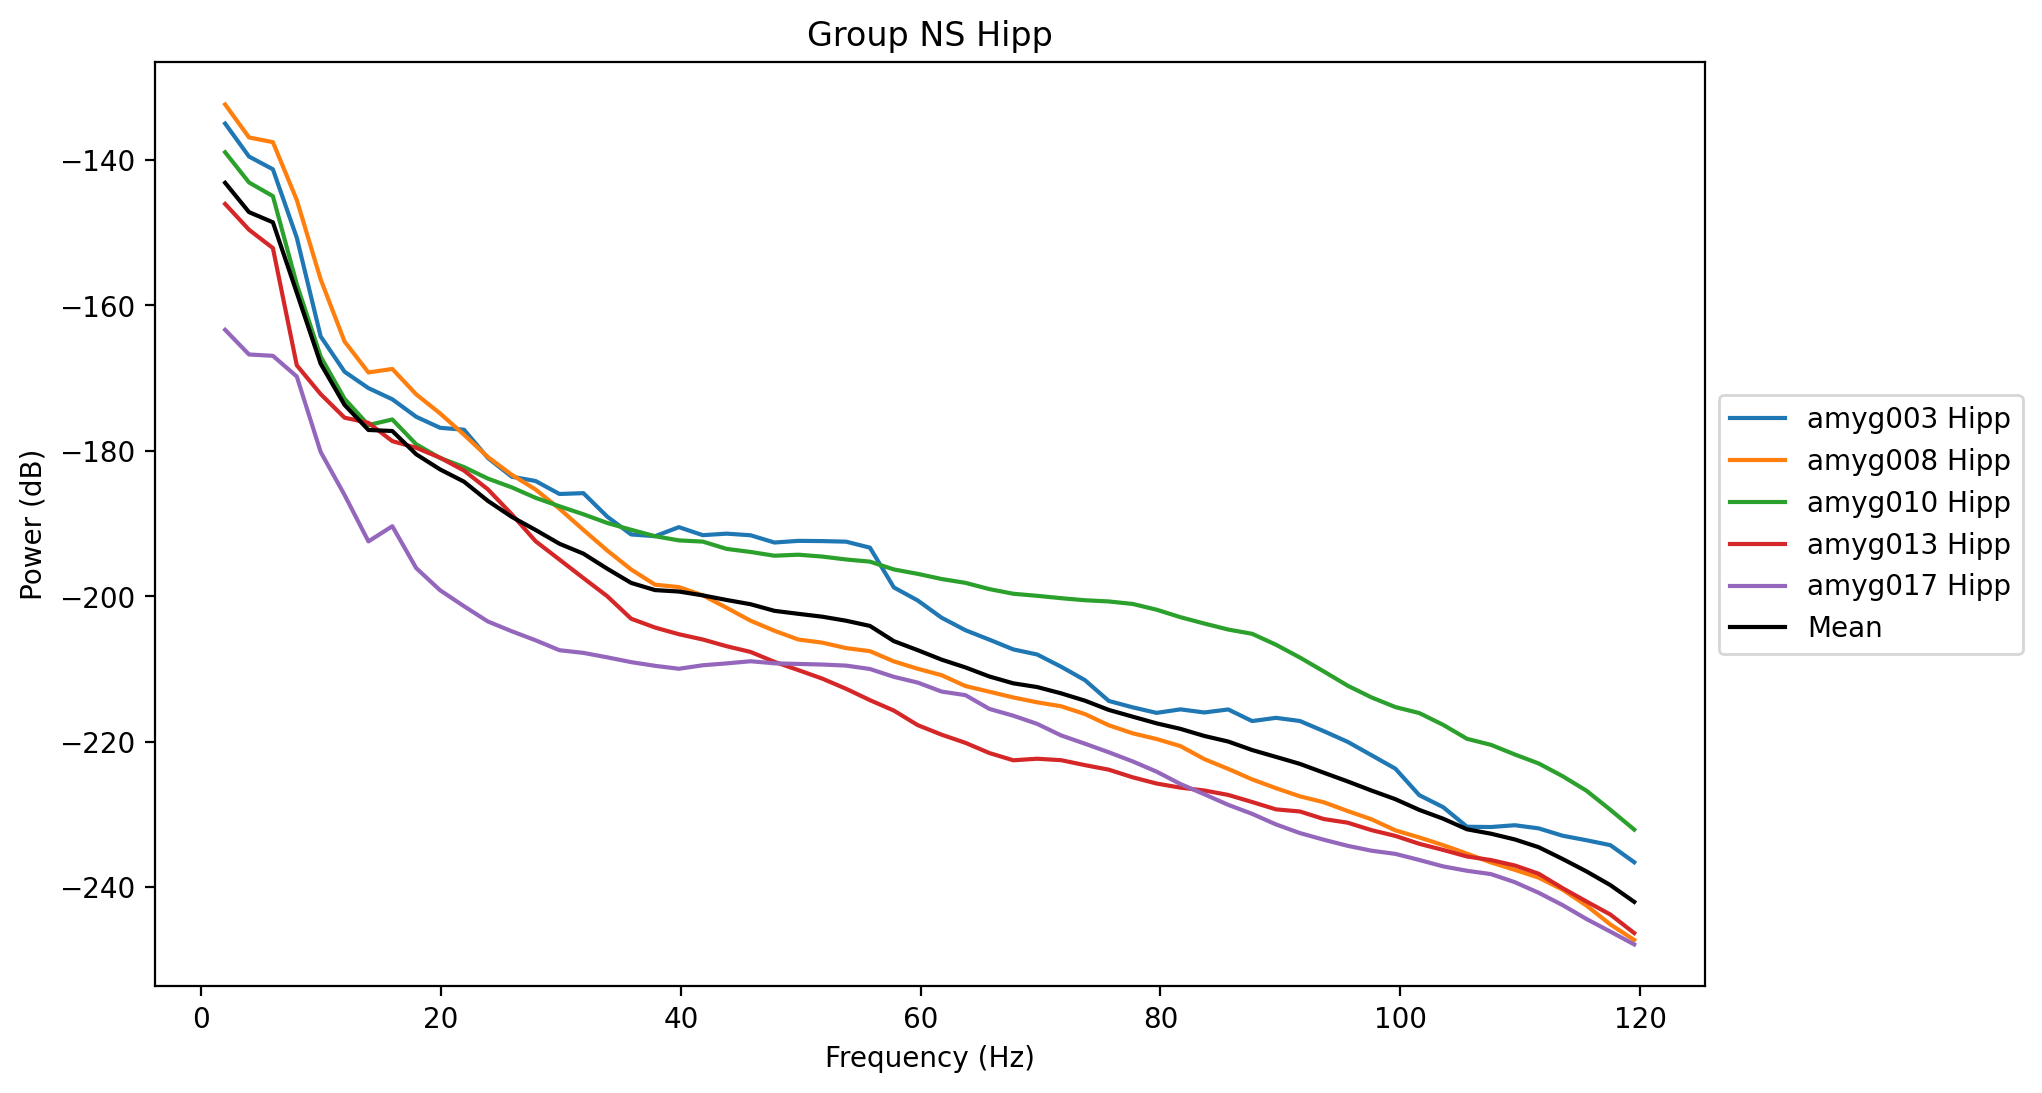

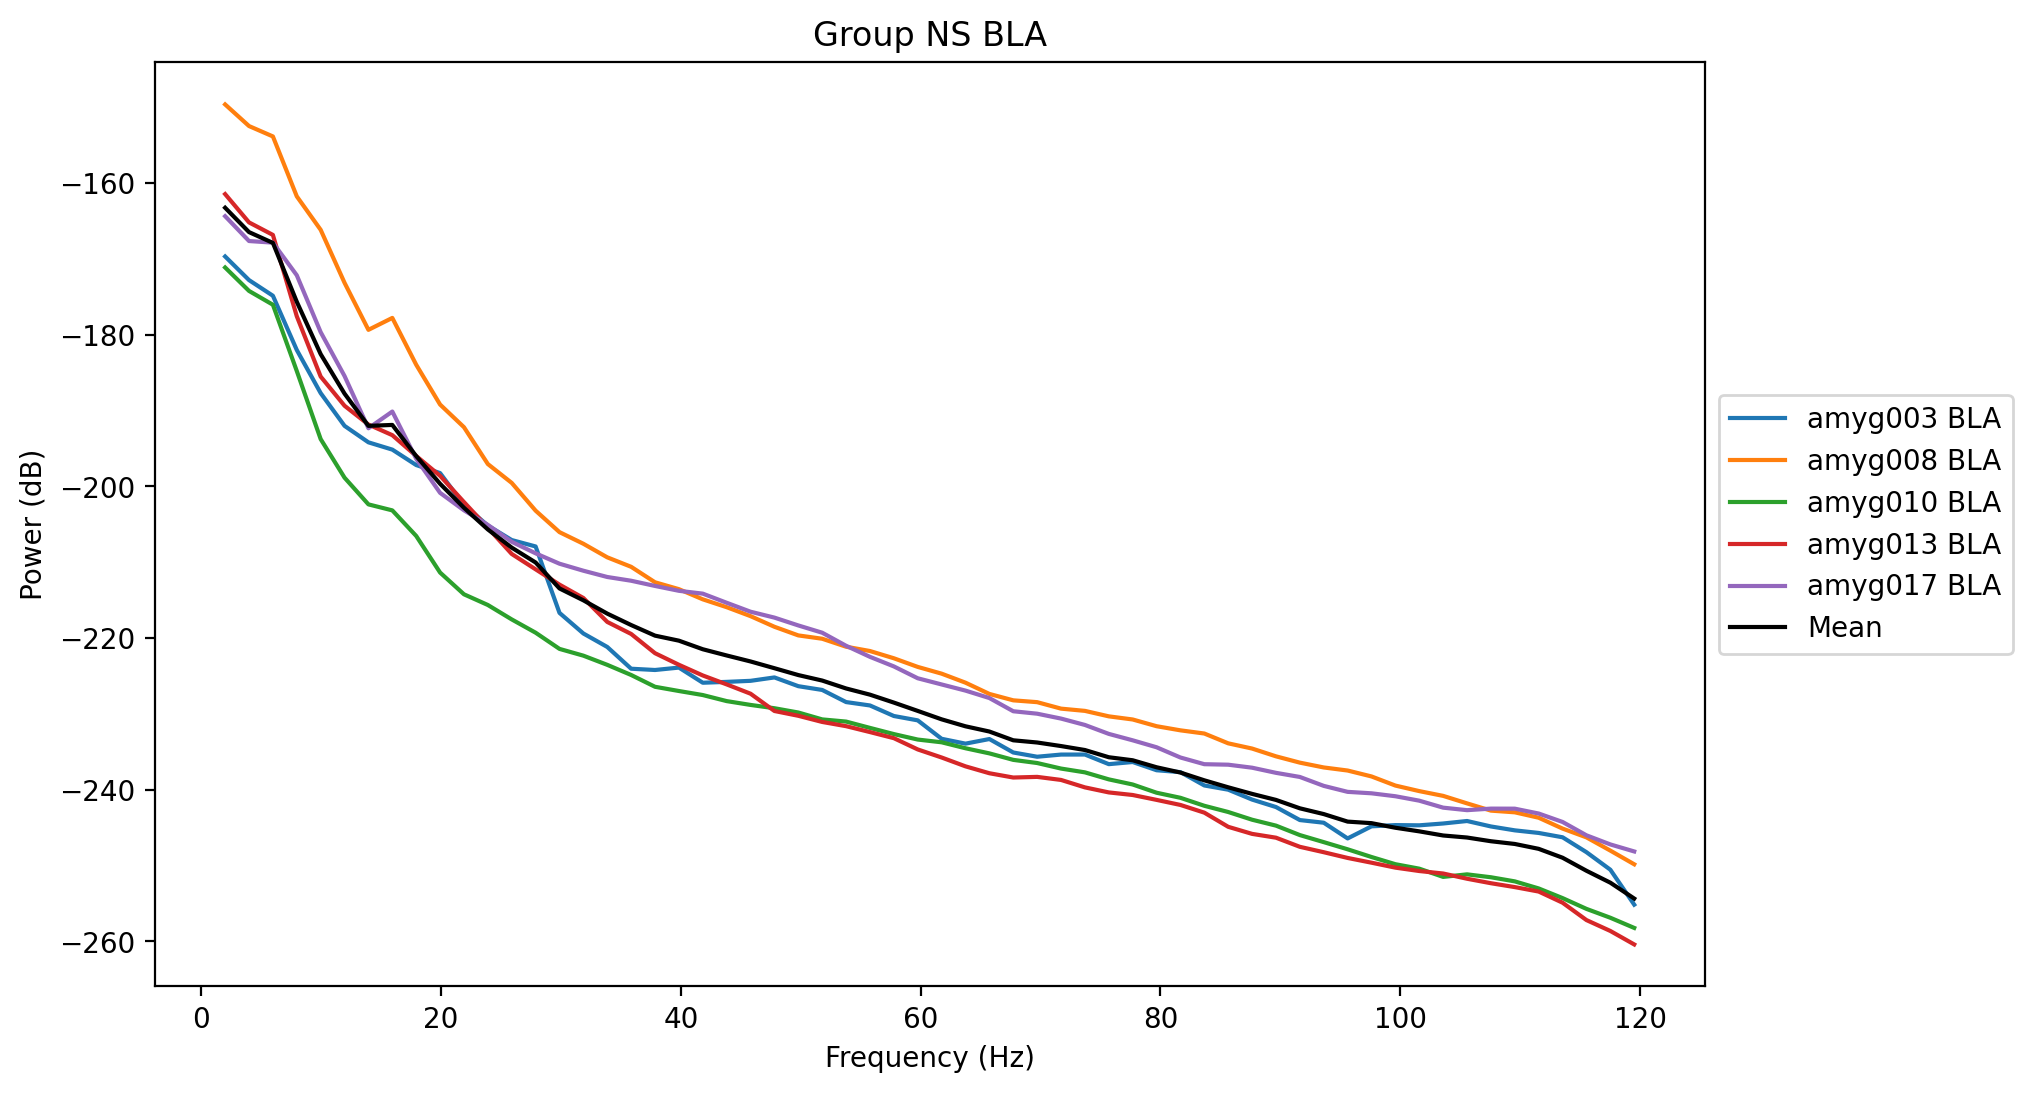

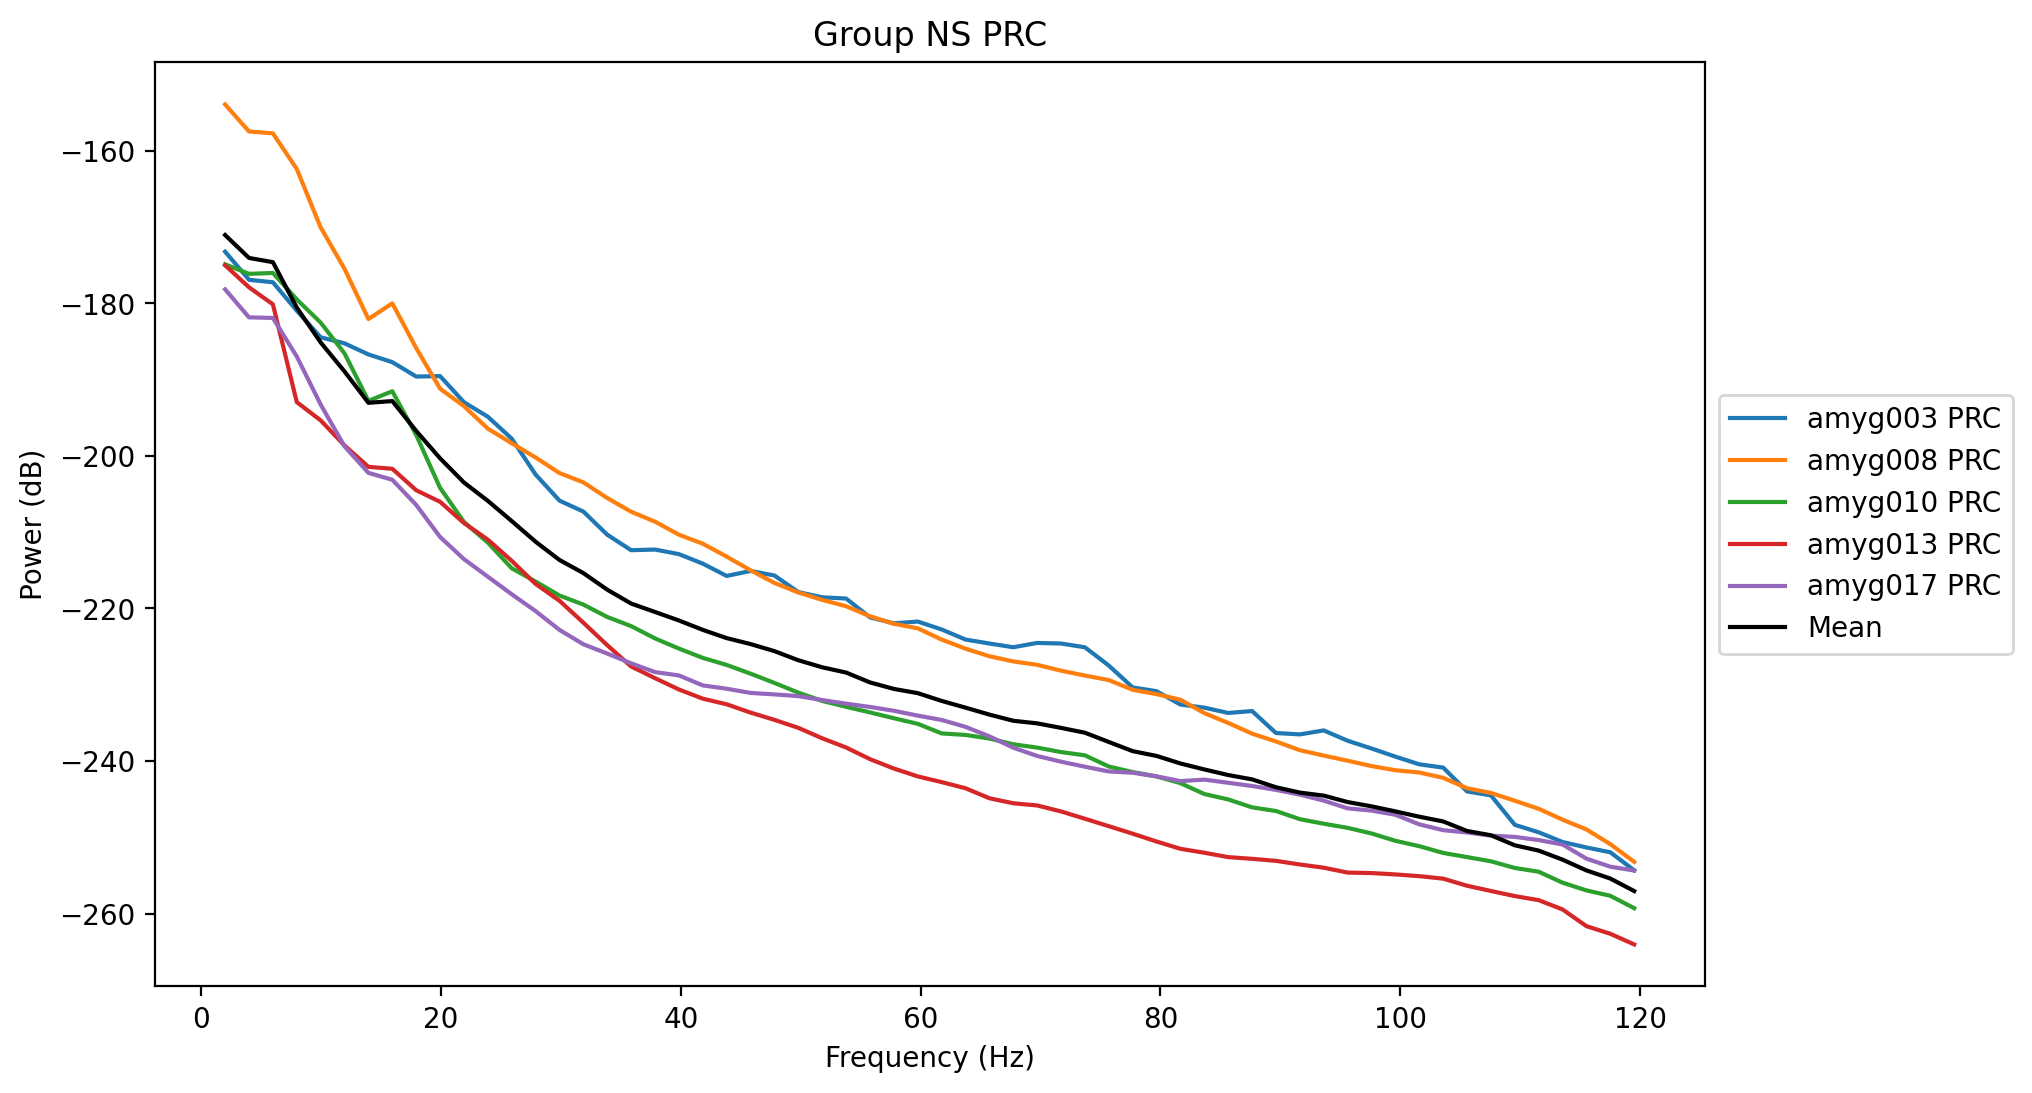

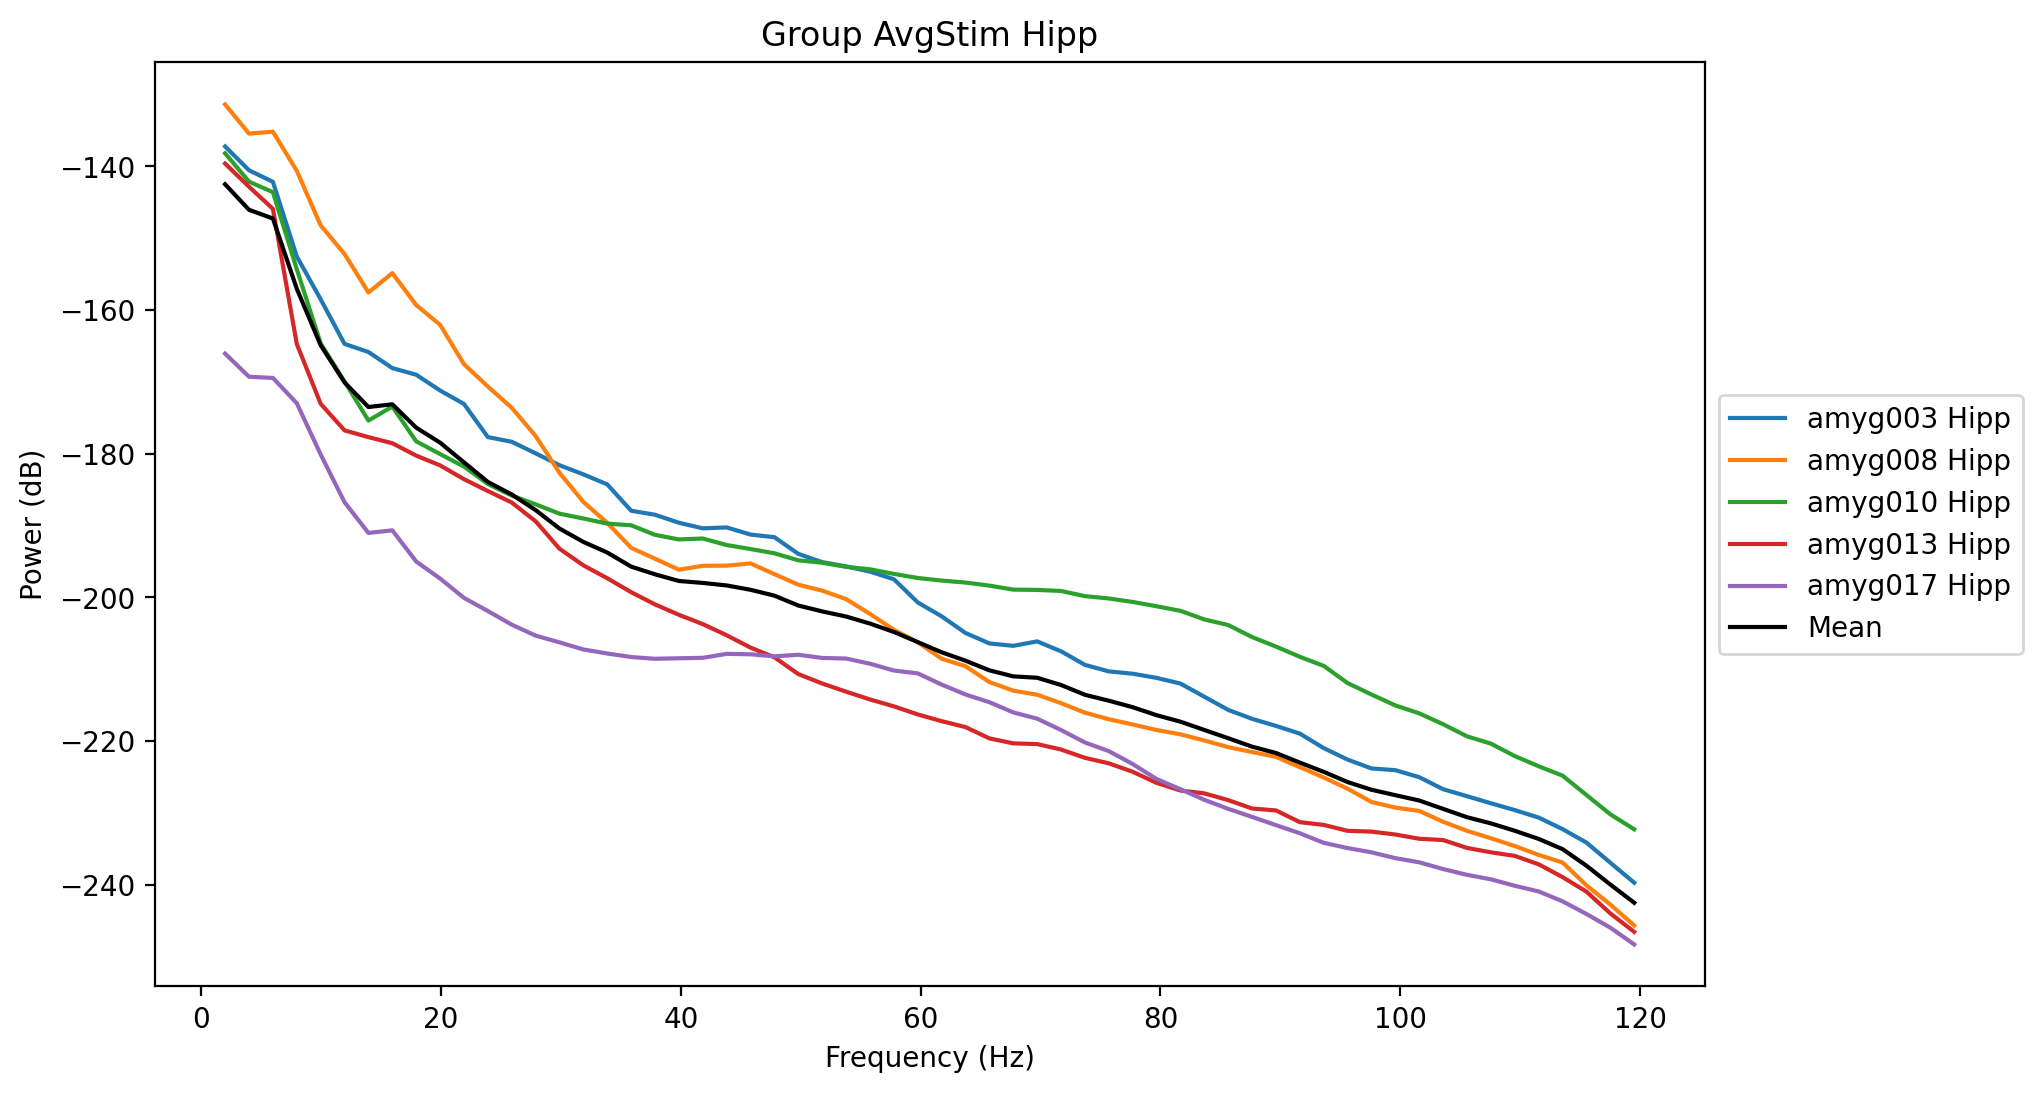

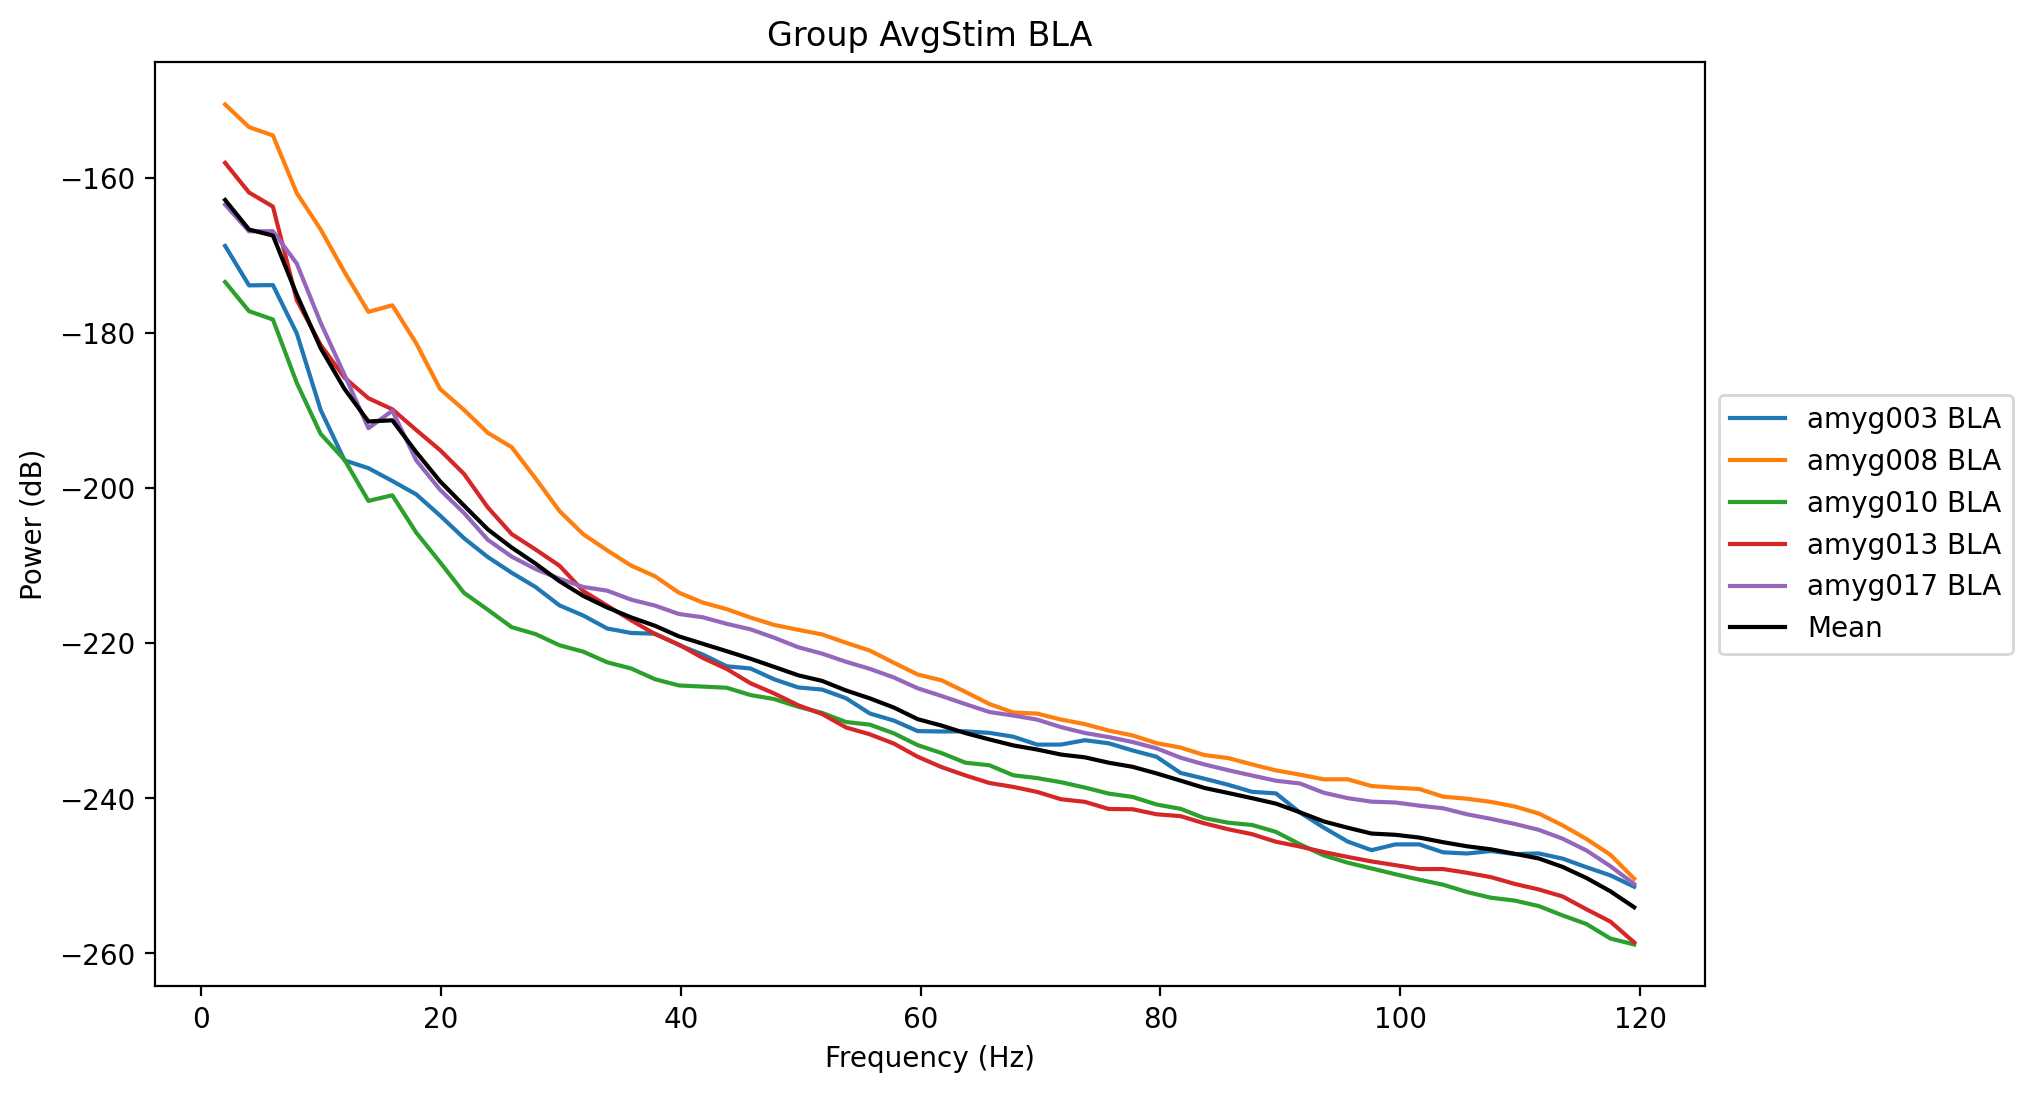

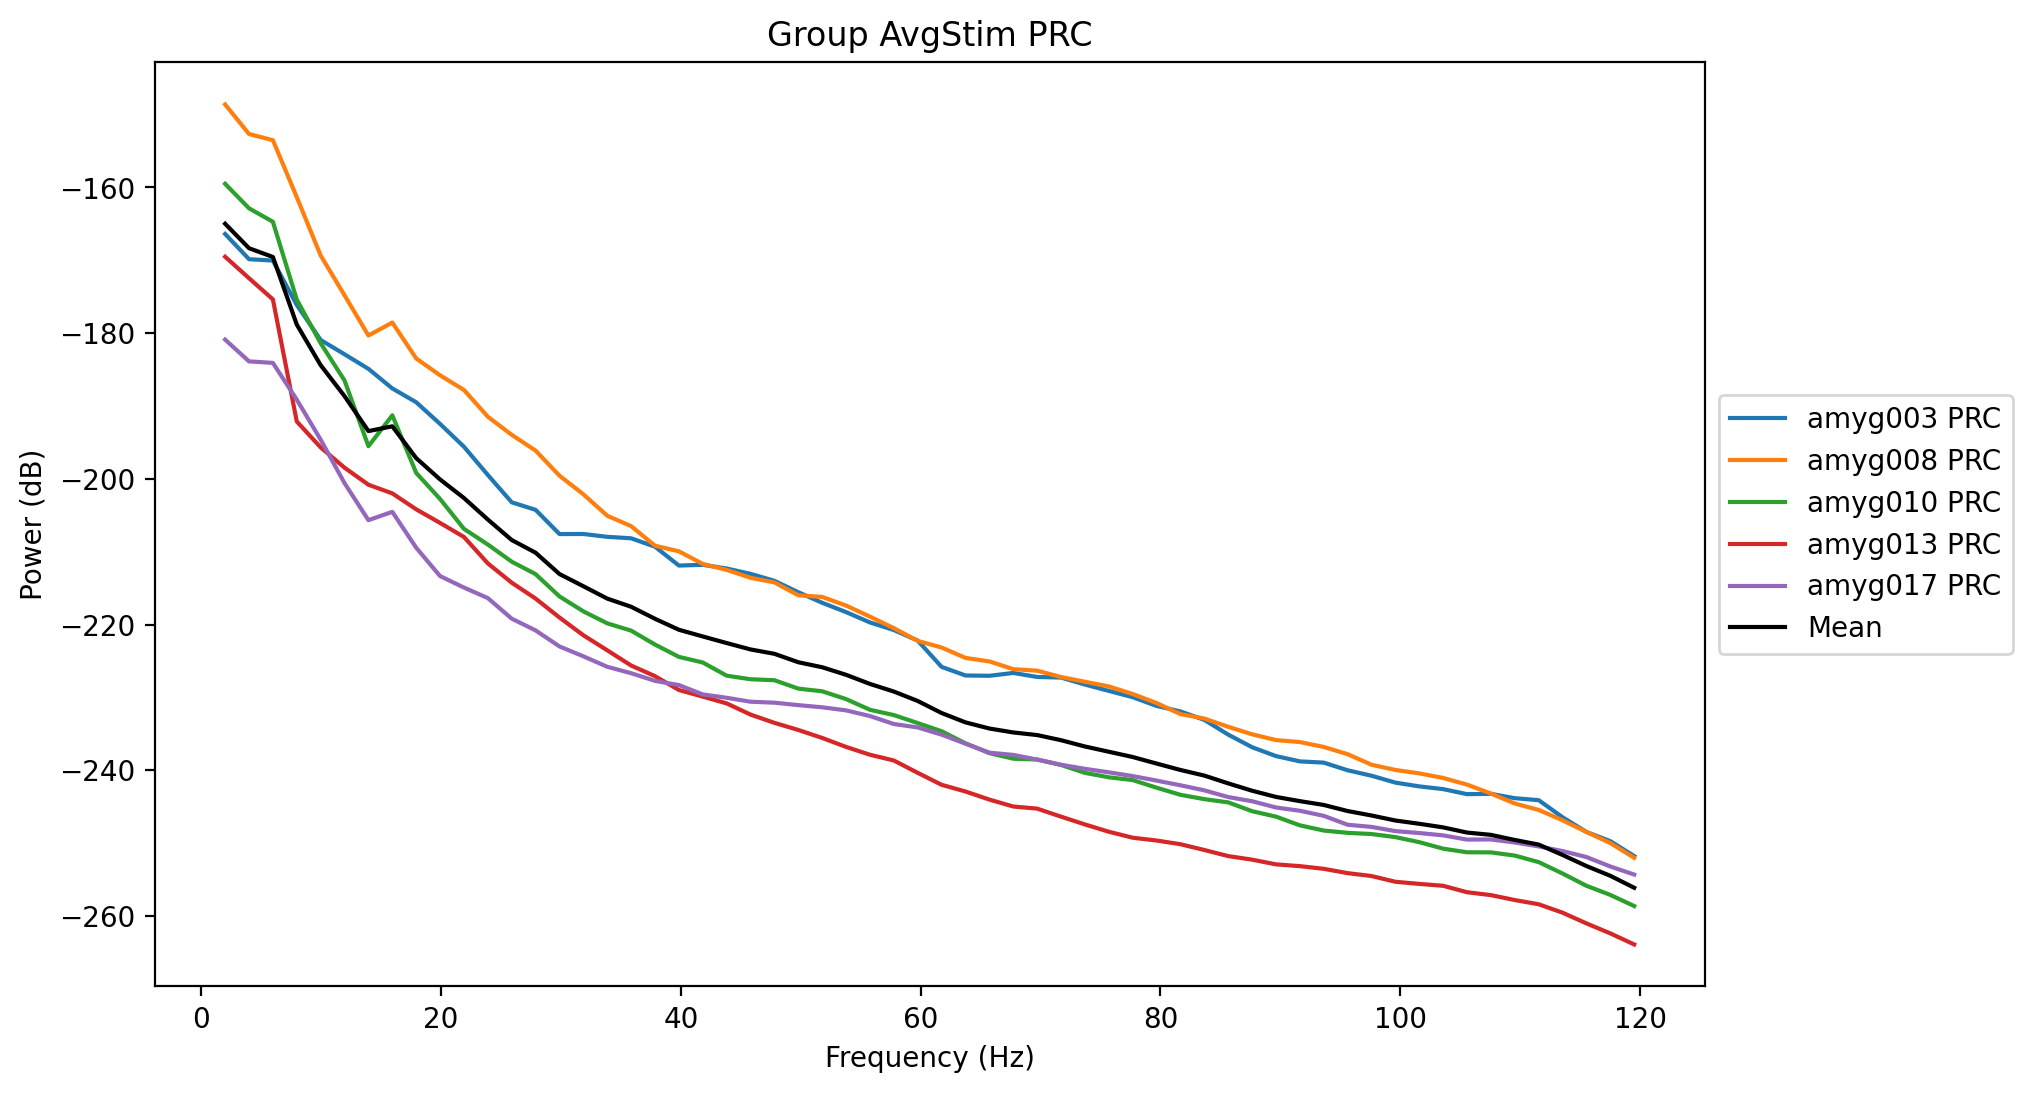

In [8]:
# Plot NS and AvgStim for each individual subject so you can see how it averaged
conditions = {
    'NS': group_ns_power,
    'AvgStim': group_avg_power,
    #'OneStim': group_onestim_power,
    #'ThreeStim': group_threestim_power,
    #'BeforeStim': group_beforestim_power,
    #'DuringStim': group_duringstim_power,
    #'AfterStim': group_afterstim_power,
}

for stim_condition, power_data,  in conditions.items():
    for roi in ROIs:
        plt.figure(figsize=(10, 6))

        all_power = []

        #print(power_data[roi])
        for subject, power in power_data[roi].items():
            # Generate x values
            #x = np.arange(1, 120, 2)
            # Create the plot
            plt.plot(freqs, power, label=f'{subject} {roi}')
            all_power.append(power)

        all_power = np.array(all_power)
        # Calculate the mean and standard deviation
        mean = np.mean(all_power, axis=0)
        plt.plot(freqs, mean, label='Mean', color='black')

        # Add labels and legend
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power (dB)')
        plt.title(f'Group {stim_condition} {roi}')
        #put legend outside of plot
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # Show the plot
        plt.savefig(os.path.join(group_results_path, f'Group_{stim_condition}_{roi}_Power.png'))
        plt.show()



## Plot bar graph of theta and gamma stim vs no stim differences

In [9]:
 # Read in each subjects AvgStim and NS power for each ROI

freq_band_avg_diff_data = {
    'theta': defaultdict(dict),
    'gamma': defaultdict(dict),
}
freq_band_one_diff_data = {
    'theta': defaultdict(dict),
    'gamma': defaultdict(dict),
}
freq_band_three_diff_data = {
    'theta': defaultdict(dict),
    'gamma': defaultdict(dict),
}
freq_band_before_diff_data = {
    'theta': defaultdict(dict),
    'gamma': defaultdict(dict),
}
freq_band_during_diff_data = {
    'theta': defaultdict(dict),
    'gamma': defaultdict(dict),
}
freq_band_after_diff_data = {
    'theta': defaultdict(dict),
    'gamma': defaultdict(dict),
}

for freq_band in freq_band_avg_diff_data.keys():
    for subject in subjects:
        datapath = os.path.join(project_path, subject)
        preproDataPath = os.path.join(datapath, 'PreprocessedData', 'Joes_preprocessing')

        for roi in ROIs:
            # Check if the ROI power for avg exists
            roi_avg_filename = f'ROI_{roi}_avg_vs_ns_power_{freq_band}_remembered.npy'
            if not os.path.isfile(os.path.join(preproDataPath, roi_avg_filename)):
                print(f"WARNING: Subject {subject} is missing avg {freq_band} {roi} file, expected here: {os.path.join(preproDataPath, roi_avg_filename)}")
                continue
            subj_avg_freq_band_diff = np.load(os.path.join(preproDataPath, roi_avg_filename))
            print(f"Subject: {subject} | {roi} {freq_band} Found AVG minus NS file: {roi_avg_filename}")
            freq_band_avg_diff_data[freq_band][roi][subject] = subj_avg_freq_band_diff
'''
            ##### AMME DURATION DATA #####  

            roi_onestim_filename = f'ROI_{roi}_onestim_vs_ns_power_{freq_band}.npy'
            if not os.path.isfile(os.path.join(preproDataPath, roi_onestim_filename)):
                print(f"WARNING: Subject {subject} is missing onestim {freq_band} {roi} file, expected here: {os.path.join(preproDataPath, roi_onestim_filename)}")
            else:
                subj_onestim_freq_band_diff = np.load(os.path.join(preproDataPath, roi_onestim_filename))
                freq_band_one_diff_data[freq_band][roi][subject] = subj_onestim_freq_band_diff
                print(f"Subject: {subject} | {roi} {freq_band} Found ONESTIM minus NS file: {roi_onestim_filename}")

            roi_threestim_filename = f'ROI_{roi}_threestim_vs_ns_power_{freq_band}.npy'
            if not os.path.isfile(os.path.join(preproDataPath, roi_threestim_filename)):
                print(f"WARNING: Subject {subject} is missing threestim {freq_band} {roi} file, expected here: {os.path.join(preproDataPath, roi_threestim_filename)}")
            else:
                subj_threestim_freq_band_diff = np.load(os.path.join(preproDataPath, roi_threestim_filename))
                freq_band_three_diff_data[freq_band][roi][subject] = subj_threestim_freq_band_diff
                print(f"Subject: {subject} | {roi} {freq_band} Found THREESTIM minus NS file: {roi_threestim_filename}")

            ##### AMME TIMING DATA #####    

            roi_beforestim_filename = f'ROI_{roi}_before_vs_ns_power_{freq_band}.npy'
            if not os.path.isfile(os.path.join(preproDataPath, roi_beforestim_filename)):
                print(f"WARNING: Subject {subject} is missing before {freq_band} {roi} file, expected here: {os.path.join(preproDataPath, roi_beforestim_filename)}")
            else:
                subj_beforestim_freq_band_diff = np.load(os.path.join(preproDataPath, roi_beforestim_filename))
                freq_band_before_diff_data[freq_band][roi][subject] = subj_beforestim_freq_band_diff
                print(f"Subject: {subject} | {roi} {freq_band} Found BEFORE minus NS file: {roi_beforestim_filename}")

            roi_duringstim_filename = f'ROI_{roi}_during_vs_ns_power_{freq_band}.npy'
            if not os.path.isfile(os.path.join(preproDataPath, roi_duringstim_filename)):
                print(f"WARNING: Subject {subject} is missing during {freq_band} {roi} file, expected here: {os.path.join(preproDataPath, roi_duringstim_filename)}")
            else:
                subj_duringstim_freq_band_diff = np.load(os.path.join(preproDataPath, roi_duringstim_filename))
                freq_band_during_diff_data[freq_band][roi][subject] = subj_duringstim_freq_band_diff
                print(f"Subject: {subject} | {roi} {freq_band} Found DURING minus NS file: {roi_duringstim_filename}")

            roi_afterstim_filename = f'ROI_{roi}_after_vs_ns_power_{freq_band}.npy'
            if not os.path.isfile(os.path.join(preproDataPath, roi_afterstim_filename)):
                print(f"WARNING: Subject {subject} is missing after {freq_band} {roi} file, expected here: {os.path.join(preproDataPath, roi_afterstim_filename)}")
            else:
                subj_afterstim_freq_band_diff = np.load(os.path.join(preproDataPath, roi_afterstim_filename))
                freq_band_after_diff_data[freq_band][roi][subject] = subj_afterstim_freq_band_diff
                print(f"Subject: {subject} | {roi} {freq_band} Found AFTER minus NS file: {roi_afterstim_filename}")
'''


Subject: amyg003 | Hipp theta Found AVG minus NS file: ROI_Hipp_avg_vs_ns_power_theta_remembered.npy
Subject: amyg003 | BLA theta Found AVG minus NS file: ROI_BLA_avg_vs_ns_power_theta_remembered.npy
Subject: amyg003 | PRC theta Found AVG minus NS file: ROI_PRC_avg_vs_ns_power_theta_remembered.npy
Subject: amyg008 | Hipp theta Found AVG minus NS file: ROI_Hipp_avg_vs_ns_power_theta_remembered.npy
Subject: amyg008 | BLA theta Found AVG minus NS file: ROI_BLA_avg_vs_ns_power_theta_remembered.npy
Subject: amyg008 | PRC theta Found AVG minus NS file: ROI_PRC_avg_vs_ns_power_theta_remembered.npy
Subject: amyg010 | Hipp theta Found AVG minus NS file: ROI_Hipp_avg_vs_ns_power_theta_remembered.npy
Subject: amyg010 | BLA theta Found AVG minus NS file: ROI_BLA_avg_vs_ns_power_theta_remembered.npy
Subject: amyg010 | PRC theta Found AVG minus NS file: ROI_PRC_avg_vs_ns_power_theta_remembered.npy
Subject: amyg013 | Hipp theta Found AVG minus NS file: ROI_Hipp_avg_vs_ns_power_theta_remembered.npy
Su

'\n           ##### AMME DURATION DATA #####  \n\n           roi_onestim_filename = f\'ROI_{roi}_onestim_vs_ns_power_{freq_band}.npy\'\n           if not os.path.isfile(os.path.join(preproDataPath, roi_onestim_filename)):\n               print(f"WARNING: Subject {subject} is missing onestim {freq_band} {roi} file, expected here: {os.path.join(preproDataPath, roi_onestim_filename)}")\n           else:\n               subj_onestim_freq_band_diff = np.load(os.path.join(preproDataPath, roi_onestim_filename))\n               freq_band_one_diff_data[freq_band][roi][subject] = subj_onestim_freq_band_diff\n               print(f"Subject: {subject} | {roi} {freq_band} Found ONESTIM minus NS file: {roi_onestim_filename}")\n\n           roi_threestim_filename = f\'ROI_{roi}_threestim_vs_ns_power_{freq_band}.npy\'\n           if not os.path.isfile(os.path.join(preproDataPath, roi_threestim_filename)):\n               print(f"WARNING: Subject {subject} is missing threestim {freq_band} {roi} file, e

Running AvgStim
       subj   roi   freq  Power (dB)
0   amyg003  Hipp  theta   -1.360411
1   amyg008  Hipp  theta    3.637364
2   amyg010  Hipp  theta    2.087422
3   amyg013  Hipp  theta    4.858369
4   amyg017  Hipp  theta   -2.864453
5   amyg003   BLA  theta    1.507311
6   amyg008   BLA  theta   -0.432494
7   amyg010   BLA  theta   -1.926584
8   amyg013   BLA  theta    2.478784
9   amyg017   BLA  theta    1.057565
10  amyg003   PRC  theta    6.009010
11  amyg008   PRC  theta    2.611502
12  amyg010   PRC  theta    7.682186
13  amyg013   PRC  theta    2.782708
14  amyg017   PRC  theta   -2.173283
15  amyg003  Hipp  gamma    0.952737
16  amyg008  Hipp  gamma    5.485565
17  amyg010  Hipp  gamma    0.168876
18  amyg013  Hipp  gamma    1.485187
19  amyg017  Hipp  gamma    0.987192
20  amyg003   BLA  gamma    2.788002
21  amyg008   BLA  gamma    0.868534
22  amyg010   BLA  gamma    1.673660
23  amyg013   BLA  gamma    2.427470
24  amyg017   BLA  gamma   -1.941582
25  amyg003   PRC  gam

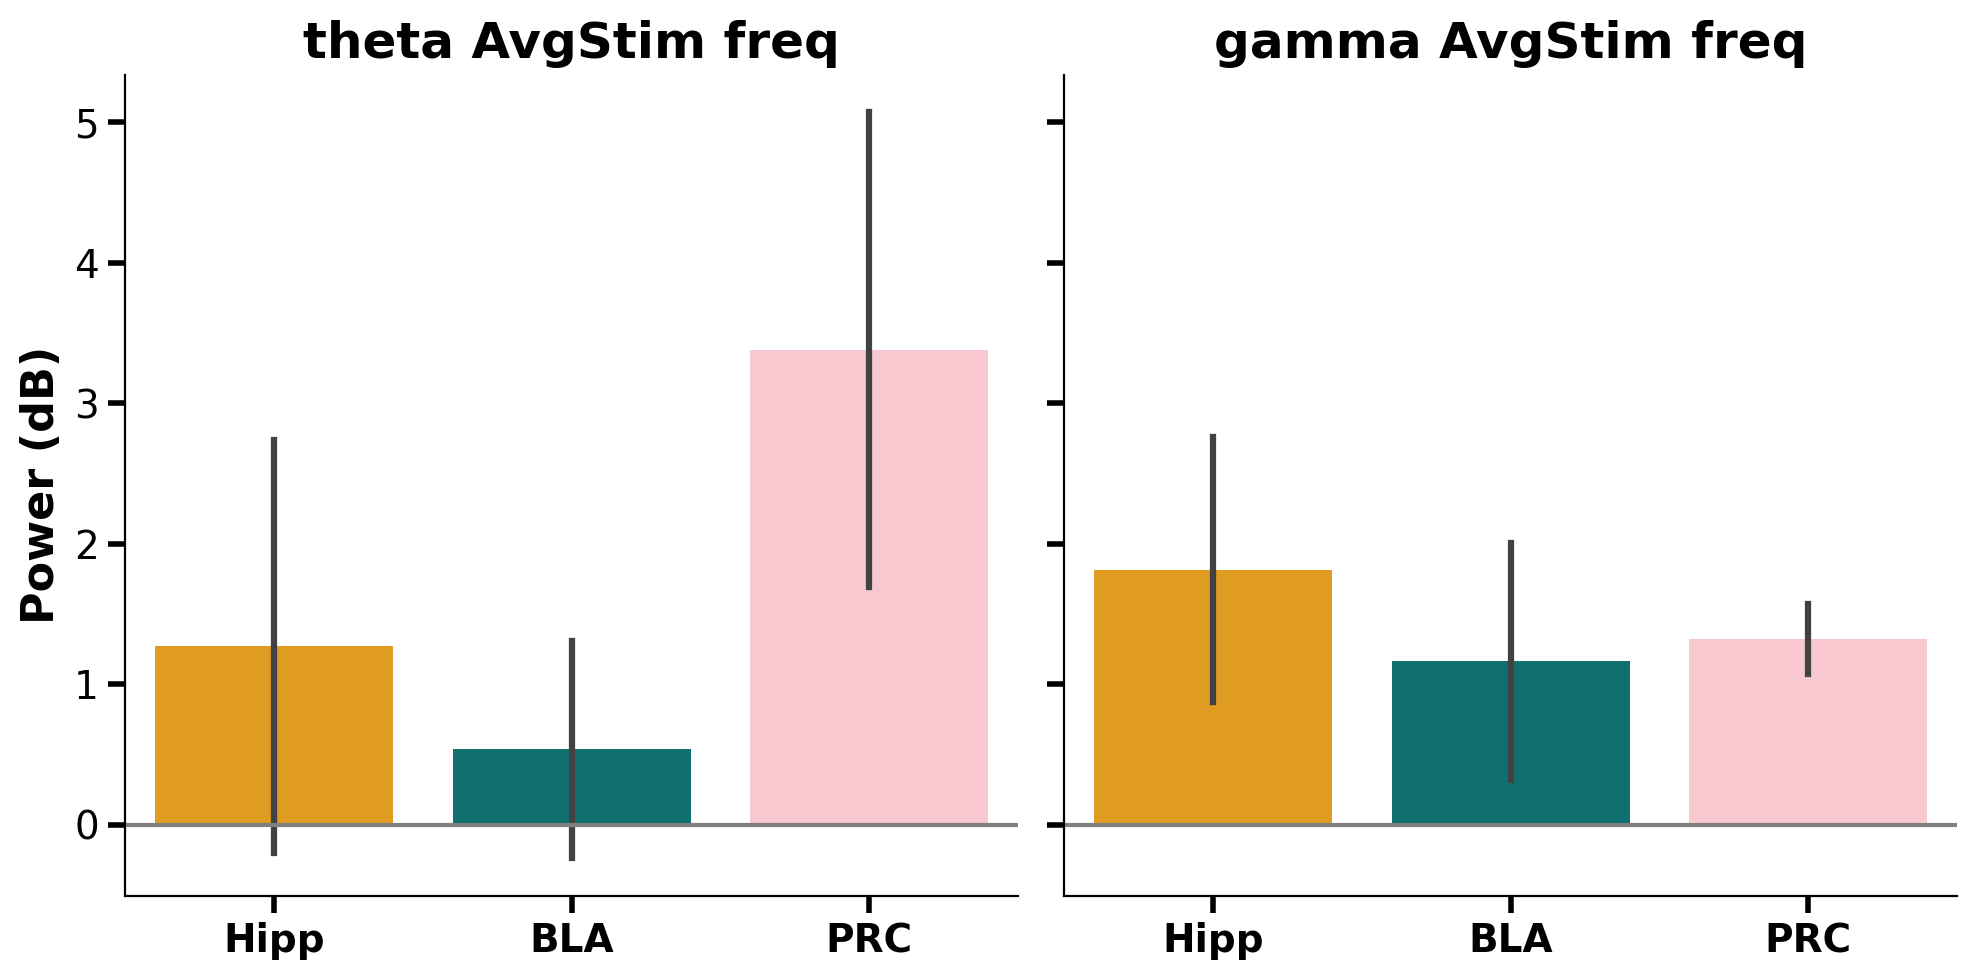

In [10]:
roi_colors = {
    'Hipp': '#FFA500',  # orange
    'PRC': '#FFC0CB',  # magenta
    'BLA': '#008080',   # teal
    #'EC': '#800080',    # purple
    #'MTL': '#000000' # black
}

df_avg_raw = []
df_one_raw = []
df_three_raw = []
df_before_raw = []
df_during_raw = []
df_after_raw = []

for freq in freq_band_avg_diff_data.keys():
    for roi in freq_band_avg_diff_data[freq].keys():
        for subj in freq_band_avg_diff_data[freq][roi].keys():
            df_avg_raw.append({'subj': subj, 'roi': roi, 'freq': freq, 'Power (dB)': float(freq_band_avg_diff_data[freq][roi][subj])})
'''
for freq in freq_band_one_diff_data.keys():
    for roi in freq_band_one_diff_data[freq].keys():
        for subj in freq_band_one_diff_data[freq][roi].keys():
            df_one_raw.append({'subj': subj, 'roi': roi, 'freq': freq, 'Power (dB)': float(freq_band_one_diff_data[freq][roi][subj])})

for freq in freq_band_three_diff_data.keys():
    for roi in freq_band_three_diff_data[freq].keys():
        for subj in freq_band_three_diff_data[freq][roi].keys():
            df_three_raw.append({'subj': subj, 'roi': roi, 'freq': freq, 'Power (dB)': float(freq_band_three_diff_data[freq][roi][subj])})

for freq in freq_band_before_diff_data.keys():
    for roi in freq_band_before_diff_data[freq].keys():
        for subj in freq_band_before_diff_data[freq][roi].keys():
            df_before_raw.append({'subj': subj, 'roi': roi, 'freq': freq, 'Power (dB)': float(freq_band_before_diff_data[freq][roi][subj])})

for freq in freq_band_during_diff_data.keys():
    for roi in freq_band_during_diff_data[freq].keys():
        for subj in freq_band_during_diff_data[freq][roi].keys():
            df_during_raw.append({'subj': subj, 'roi': roi, 'freq': freq, 'Power (dB)': float(freq_band_during_diff_data[freq][roi][subj])})

for freq in freq_band_after_diff_data.keys():
    for roi in freq_band_after_diff_data[freq].keys():
        for subj in freq_band_after_diff_data[freq][roi].keys():
            df_after_raw.append({'subj': subj, 'roi': roi, 'freq': freq, 'Power (dB)': float(freq_band_after_diff_data[freq][roi][subj])})
'''      

for df_name, df_raw in [
        ['AvgStim', df_avg_raw] #['OneStim', df_one_raw], ['ThreeStim', df_three_raw], ['BeforeStim', df_before_raw], ['DuringStim', df_during_raw], ['AfterStim', df_after_raw]
    ]:
    print(f"Running {df_name}")
    plt.close()
    df = pd.DataFrame(df_raw)
    print(df)
    test_df = df[(df['roi'] == 'PRC') & (df['freq'] == 'gamma')]
    print(test_df)
    print(test_df['Power (dB)'].mean())
    palette = [roi_colors[roi] for roi in df["roi"].unique()]


    # Create the catplot with the colormap
    g = sns.catplot(
        data=df, x="roi", y="Power (dB)", col="freq",
        kind="bar", hue = 'roi', errorbar="se", palette=palette
    )
# add stripplot
    # for i, ax in enumerate(g.axes.flat):
    #     if i == 0: # theta
    #         sns.stripplot(data=df[df['freq'] == 'theta'], x="roi", y="Power (dB)", ax=ax, color='black', alpha=0.5, jitter=0.2)
    #     else: # gamma
    #         sns.stripplot(data=df[df['freq'] == 'gamma'], x="roi", y="Power (dB)", ax=ax, color='black', alpha=0.5, jitter=0.2)

    # Customize x and y labels
    for ax in g.axes.flat:
        ax.set_xlabel('')
        ax.set_ylabel(ax.get_ylabel(), fontsize=16, fontweight='bold')

    # Customize x and y ticks
    for ax in g.axes.flat:
        ax.tick_params(axis='x', labelsize=14, width=2, length=6)
        ax.tick_params(axis='y', labelsize=14, width=2, length=6)
        # Set font properties for tick labels
        for label in ax.get_xticklabels():
            label.set_fontsize(14)
            label.set_fontweight('bold')
        for label in ax.get_yticklabels():
            label.set_fontsize(14)

    # Customize legend
    for ax in g.axes.flat:
        legend = ax.get_legend()
        if legend:
            plt.setp(legend.get_texts(), fontsize=12, weight='bold')
            plt.setp(legend.get_title(), fontsize=12, weight='bold')

    # Add a horizontal line at y=0 for each subplot
    for ax in g.axes.flat:
        ax.axhline(0, linestyle='-', color='grey')


    g.set_titles("{col_name} " + df_name + " {col_var}",size=18, weight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(group_results_path, f'Bargraph_{df_name}_diff.png'))
    plt.show()


In [14]:
# Run a linear mixed-effects model for each ROI and frequency band
for df_name, df_raw in [
        ['AvgStim', df_avg_raw] #['OneStim', df_one_raw], ['ThreeStim', df_three_raw], ['BeforeStim', df_before_raw], ['DuringStim', df_during_raw], ['AfterStim', df_after_raw]
    ]:
    df = pd.DataFrame(df_raw)

    for freq in ['theta', 'gamma']:
        print(f"Running {df_name} {freq} Linear Mixed-Effects Model")
        df_freq = df[df['freq'] == freq]
        
        # Define the model
        model = mixedlm("Q('Power (dB)') ~ roi", df_freq, groups=df_freq["subj"])
        
        # Fit the model
        result = model.fit()
        
        # Print the summary
        summary = str(result.summary())
        with open(os.path.join(group_results_path, f'LMM_RESULT_{df_name}_{freq}_lmm.txt'), 'w') as f:
            f.write(summary)
        print(summary)

Running AvgStim theta Linear Mixed-Effects Model
            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Q('Power (dB)')
No. Observations: 15      Method:             REML           
No. Groups:       5       Scale:              9.1805         
Min. group size:  3       Log-Likelihood:     -32.8600       
Max. group size:  3       Converged:          Yes            
Mean group size:  3.0                                        
--------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept        0.537     1.368  0.392  0.695  -2.145   3.219
roi[T.Hipp]      0.735     1.916  0.383  0.701  -3.021   4.491
roi[T.PRC]       2.846     1.916  1.485  0.138  -0.910   6.601
Group Var        0.183     0.927                              

Running AvgStim gamma Linear Mixed-Effects Model
            Mixed Linear Model Regress

In [15]:
ttest_comparisons = [
    ['Hipp', 'BLA'],
    ['Hipp', 'PRC'],
    ['Hipp', 'EC'],
    ['Hipp', 'MTL'],
    ['BLA', 'PRC'],
    ['BLA', 'EC'],
    ['BLA', 'MTL'],
    ['PRC', 'EC'],
    ['PRC', 'MTL'],
    ['EC', 'MTL'],
]


# Run a linear mixed-effects model for each ROI and frequency band
for df_name, df_raw in [
        ['AvgStim', df_avg_raw] # ['OneStim', df_one_raw], ['ThreeStim', df_three_raw], ['BeforeStim', df_before_raw], ['DuringStim', df_during_raw], ['AfterStim', df_after_raw]
    ]:
    df = pd.DataFrame(df_raw)

    for freq in ['theta', 'gamma']:
        print(f"==================== Running {df_name} {freq} TTEST individual ====================")
        df_freq = df[df['freq'] == freq]

        for roi1, roi2 in ttest_comparisons:
            df_roi1 = df_freq[df_freq['roi'] == roi1]
            df_roi2 = df_freq[df_freq['roi'] == roi2]
            print(roi1, roi2)
            print(df_roi1.shape[0], df_roi2.shape[0])

            # Run a paired t-test
            tVals, pVals = ttest_ind(df_roi1['Power (dB)'].values, df_roi2['Power (dB)'].values, nan_policy='omit', axis = 0, equal_var=False, random_state=0)
            significant = pVals < 0.005
            print(f"{significant} Running t-test for {roi1} vs {roi2} in {df_name} {freq}: PValue: {pVals} ")

            # with open(os.path.join(group_results_path, f'TTEST_RESULT_{df_name}_{freq}_{roi1}_vs_{roi2}.txt'), 'w') as f:
            #     f.write(str(ttest_result))
        
        


==================== Running AvgStim theta TTEST individual ====================
Hipp BLA
5 5
False Running t-test for Hipp vs BLA in AvgStim theta: PValue: 0.6735118188992157 
Hipp PRC
5 5
False Running t-test for Hipp vs PRC in AvgStim theta: PValue: 0.3741764256130655 
Hipp EC
5 0
False Running t-test for Hipp vs EC in AvgStim theta: PValue: nan 
Hipp MTL
5 0
False Running t-test for Hipp vs MTL in AvgStim theta: PValue: nan 
BLA PRC
5 5
False Running t-test for BLA vs PRC in AvgStim theta: PValue: 0.18036392568138682 
BLA EC
5 0
False Running t-test for BLA vs EC in AvgStim theta: PValue: nan 
BLA MTL
5 0
False Running t-test for BLA vs MTL in AvgStim theta: PValue: nan 
PRC EC
5 0
False Running t-test for PRC vs EC in AvgStim theta: PValue: nan 
PRC MTL
5 0
False Running t-test for PRC vs MTL in AvgStim theta: PValue: nan 
EC MTL
0 0
False Running t-test for EC vs MTL in AvgStim theta: PValue: nan 
==================== Running AvgStim gamma TTEST individual ====================
Hi

In [ ]:
## NOT WORKING CURRENTLY
## ANOVA CODE

# for df_name, df_raw in [
#         ['AvgStim', df_avg_raw], ['OneStim', df_one_raw], ['ThreeStim', df_three_raw], ['BeforeStim', df_before_raw], ['DuringStim', df_during_raw], ['AfterStim', df_after_raw]
#     ]:
#     df = pd.DataFrame(df_raw)

#     for freq in ['theta', 'gamma']:
#         print(f"Running {df_name} {freq} ANOVA")
#         df_freq = df[df['freq'] == freq]
#         # Conduct the repeated measures ANOVA 
#         print(AnovaRM(data=df_freq, depvar='Power (dB)', subject='subj', within=['roi']).fit())

## 500ms - Baseline power plot for stim vs no stim

In [11]:
# Read in each subjects AvgStim and NS power for each ROI

group_ns_power_baseline = defaultdict(dict)
group_avg_power_baseline = defaultdict(dict)
'''
group_onestim_power_baseline = defaultdict(dict)
group_threestim_power_baseline = defaultdict(dict)
group_beforestim_power_baseline = defaultdict(dict)
group_duringstim_power_baseline = defaultdict(dict)
group_afterstim_power_baseline = defaultdict(dict)
'''
for subject in subjects:
    datapath = os.path.join(project_path, subject)
    preproDataPath = os.path.join(datapath, 'PreprocessedData', 'Joes_preprocessing')

    for roi in ROIs:

        ### AVG
        roi_avg_filename = f'ROI_{roi}_AvgStim_power_post_minus_baseline_remembered.npy'
        #if 'AvgStim' in roi_avg_filename:
        #    roi_filename = f'ROI_{roi}_AvgStim_power_post_minus_baseline_remembered.npy'
        #else:
        #    roi_filename = f'ROI_{roi}_Stim_power_post_minus_baseline_remembered.npy'

        avg_filepath = os.path.join(preproDataPath, roi_avg_filename)
        if not os.path.isfile(avg_filepath):
            print(f"WARNING: Subject {subject} is missing {roi} Stim_Power file, expected here: {avg_filepath}")
            continue
        else:
            print(f"Subject: {subject} | {roi} Found avg power file: {avg_filepath}")
            subj_avg_power = np.load(os.path.join(preproDataPath, roi_avg_filename)).flatten()
            group_avg_power_baseline[roi][subject] = subj_avg_power

        ### NS
        roi_ns_filename = f'ROI_{roi}_NS_power_post_minus_baseline_remembered.npy'
        ns_filepath = os.path.join(preproDataPath, roi_ns_filename)
        if not os.path.isfile(ns_filepath):
            print(f"WARNING: Subject {subject} is missing {roi} NoStim_Power file, expected here: {ns_filepath}")
            continue
        else:
            print(f"Subject: {subject} | {roi} Found nostim power file: {ns_filepath}")
            subj_ns_power = np.load(os.path.join(preproDataPath, roi_ns_filename)).flatten()
            group_ns_power_baseline[roi][subject] = subj_ns_power
'''
        ### OneSec
        roi_onesec_filename = f'ROI_{roi}_OneStim_power_post_minus_baseline.npy'
        onesec_filepath = os.path.join(preproDataPath, roi_onesec_filename)
        if not os.path.isfile(onesec_filepath):
            print(f"WARNING: Subject {subject} is missing {roi} OneStim_Power file, expected here: {onesec_filepath}")
        else:
            print(f"Subject: {subject} | {roi} Found onestim power file: {onesec_filepath}")
            subj_onesec_power = np.load(os.path.join(preproDataPath, roi_onesec_filename)).flatten()
            group_onestim_power_baseline[roi][subject] = subj_onesec_power

        ### ThreeSec
        roi_threesec_filename = f'ROI_{roi}_ThreeStim_power_post_minus_baseline.npy'
        threesec_filepath = os.path.join(preproDataPath, roi_threesec_filename)
        if not os.path.isfile(threesec_filepath):
            print(f"WARNING: Subject {subject} is missing {roi} ThreeStim_Power file, expected here: {threesec_filepath}")
        else:
            print(f"Subject: {subject} | {roi} Found threestim power file: {threesec_filepath}")
            subj_threesec_power = np.load(os.path.join(preproDataPath, roi_threesec_filename)).flatten()
            group_threestim_power_baseline[roi][subject] = subj_threesec_power

        ### BeforeStim
        roi_beforestim_filename = f'ROI_{roi}_BeforeStim_power_post_minus_baseline.npy'
        beforestim_filepath = os.path.join(preproDataPath, roi_beforestim_filename)
        if not os.path.isfile(beforestim_filepath):
            print(f"WARNING: Subject {subject} is missing {roi} BeforeStim_Power file, expected here: {beforestim_filepath}")
        else:
            print(f"Subject: {subject} | {roi} Found beforestim power file: {beforestim_filepath}")
            subj_beforestim_power = np.load(os.path.join(preproDataPath, roi_beforestim_filename)).flatten()
            group_beforestim_power_baseline[roi][subject] = subj_beforestim_power

        ### DuringStim
        roi_duringstim_filename = f'ROI_{roi}_DuringStim_power_post_minus_baseline.npy'
        duringstim_filepath = os.path.join(preproDataPath, roi_duringstim_filename)
        if not os.path.isfile(duringstim_filepath):
            print(f"WARNING: Subject {subject} is missing {roi} DuringStim_Power file, expected here: {duringstim_filepath}")
        else:
            print(f"Subject: {subject} | {roi} Found duringstim power file: {duringstim_filepath}")
            subj_duringstim_power = np.load(os.path.join(preproDataPath, roi_duringstim_filename)).flatten()
            group_duringstim_power_baseline[roi][subject] = subj_duringstim_power

        ### AfterStim
        roi_afterstim_filename = f'ROI_{roi}_AfterStim_power_post_minus_baseline.npy'
        afterstim_filepath = os.path.join(preproDataPath, roi_afterstim_filename)
        if not os.path.isfile(afterstim_filepath):
            print(f"WARNING: Subject {subject} is missing {roi} AfterStim_Power file, expected here: {afterstim_filepath}")
        else:
            print(f"Subject: {subject} | {roi} Found afterstim power file: {afterstim_filepath}")
            subj_afterstim_power = np.load(os.path.join(preproDataPath, roi_afterstim_filename)).flatten()
            group_afterstim_power_baseline[roi][subject] = subj_afterstim_power
'''

Subject: amyg003 | Hipp Found avg power file: /Users/martinahollearn/Library/CloudStorage/Box-Box/InmanLab/AMME_Data_Emory/AMME_Data/amyg003/PreprocessedData/Joes_preprocessing/ROI_Hipp_AvgStim_power_post_minus_baseline_remembered.npy
Subject: amyg003 | Hipp Found nostim power file: /Users/martinahollearn/Library/CloudStorage/Box-Box/InmanLab/AMME_Data_Emory/AMME_Data/amyg003/PreprocessedData/Joes_preprocessing/ROI_Hipp_NS_power_post_minus_baseline_remembered.npy
Subject: amyg003 | BLA Found avg power file: /Users/martinahollearn/Library/CloudStorage/Box-Box/InmanLab/AMME_Data_Emory/AMME_Data/amyg003/PreprocessedData/Joes_preprocessing/ROI_BLA_AvgStim_power_post_minus_baseline_remembered.npy
Subject: amyg003 | BLA Found nostim power file: /Users/martinahollearn/Library/CloudStorage/Box-Box/InmanLab/AMME_Data_Emory/AMME_Data/amyg003/PreprocessedData/Joes_preprocessing/ROI_BLA_NS_power_post_minus_baseline_remembered.npy
Subject: amyg003 | PRC Found avg power file: /Users/martinahollearn/

'\n        ### OneSec\n        roi_onesec_filename = f\'ROI_{roi}_OneStim_power_post_minus_baseline.npy\'\n        onesec_filepath = os.path.join(preproDataPath, roi_onesec_filename)\n        if not os.path.isfile(onesec_filepath):\n            print(f"WARNING: Subject {subject} is missing {roi} OneStim_Power file, expected here: {onesec_filepath}")\n        else:\n            print(f"Subject: {subject} | {roi} Found onestim power file: {onesec_filepath}")\n            subj_onesec_power = np.load(os.path.join(preproDataPath, roi_onesec_filename)).flatten()\n            group_onestim_power_baseline[roi][subject] = subj_onesec_power\n\n        ### ThreeSec\n        roi_threesec_filename = f\'ROI_{roi}_ThreeStim_power_post_minus_baseline.npy\'\n        threesec_filepath = os.path.join(preproDataPath, roi_threesec_filename)\n        if not os.path.isfile(threesec_filepath):\n            print(f"WARNING: Subject {subject} is missing {roi} ThreeStim_Power file, expected here: {threesec_filep

Processing ROI: Hipp


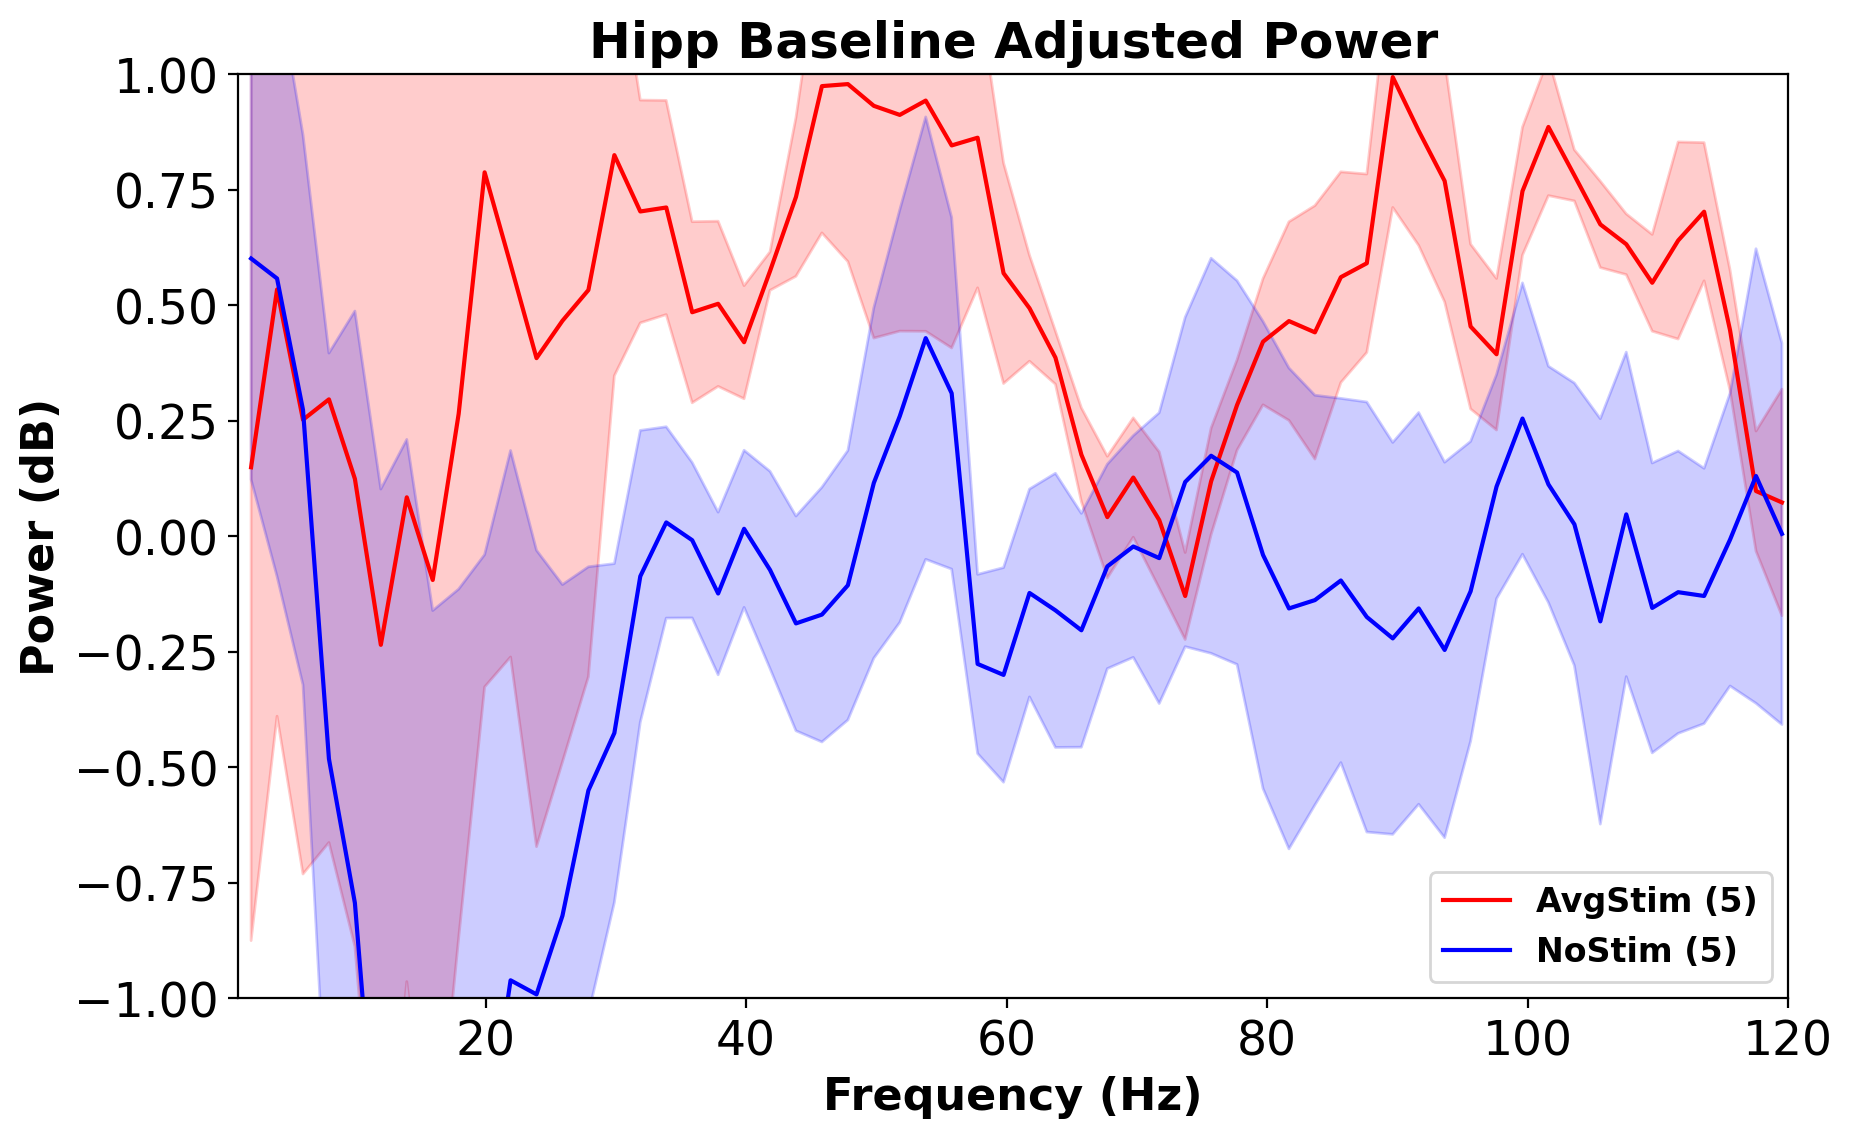

Processing ROI: BLA


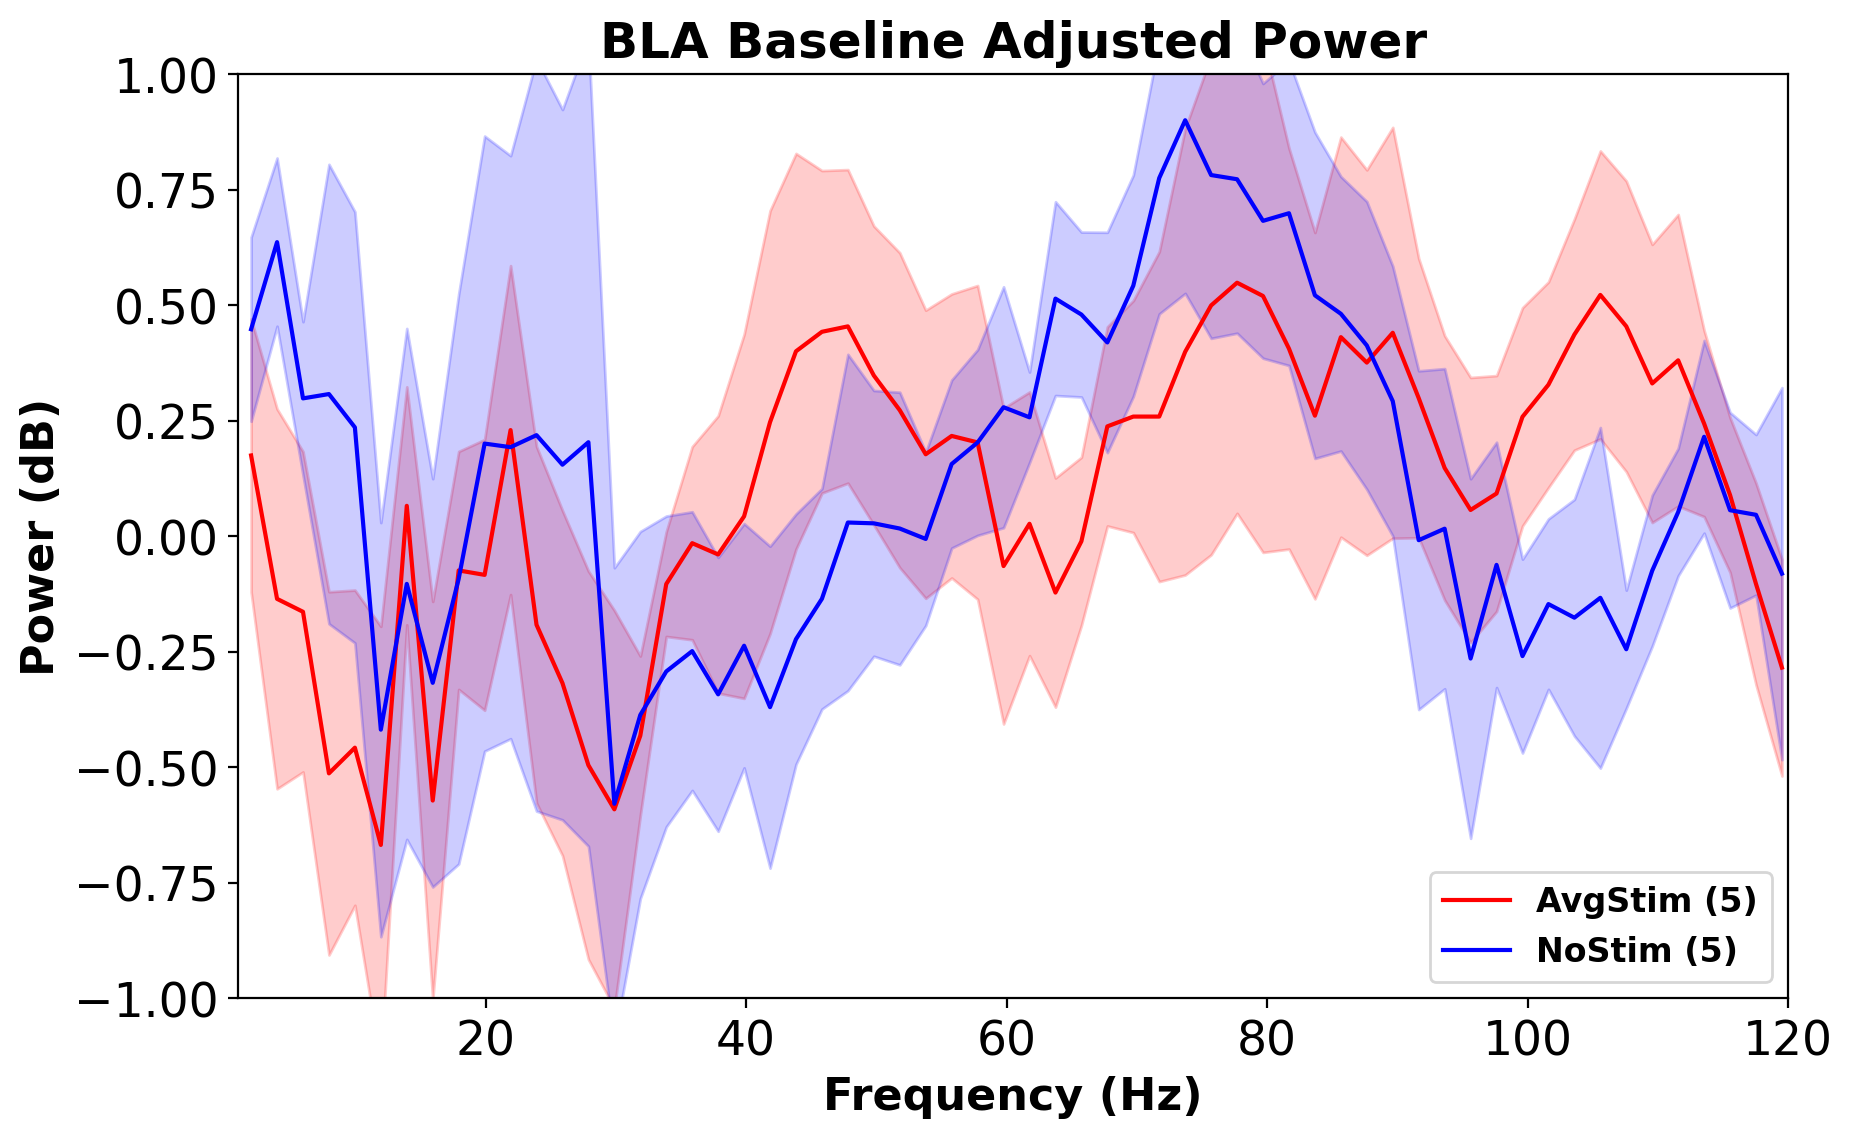

Processing ROI: PRC


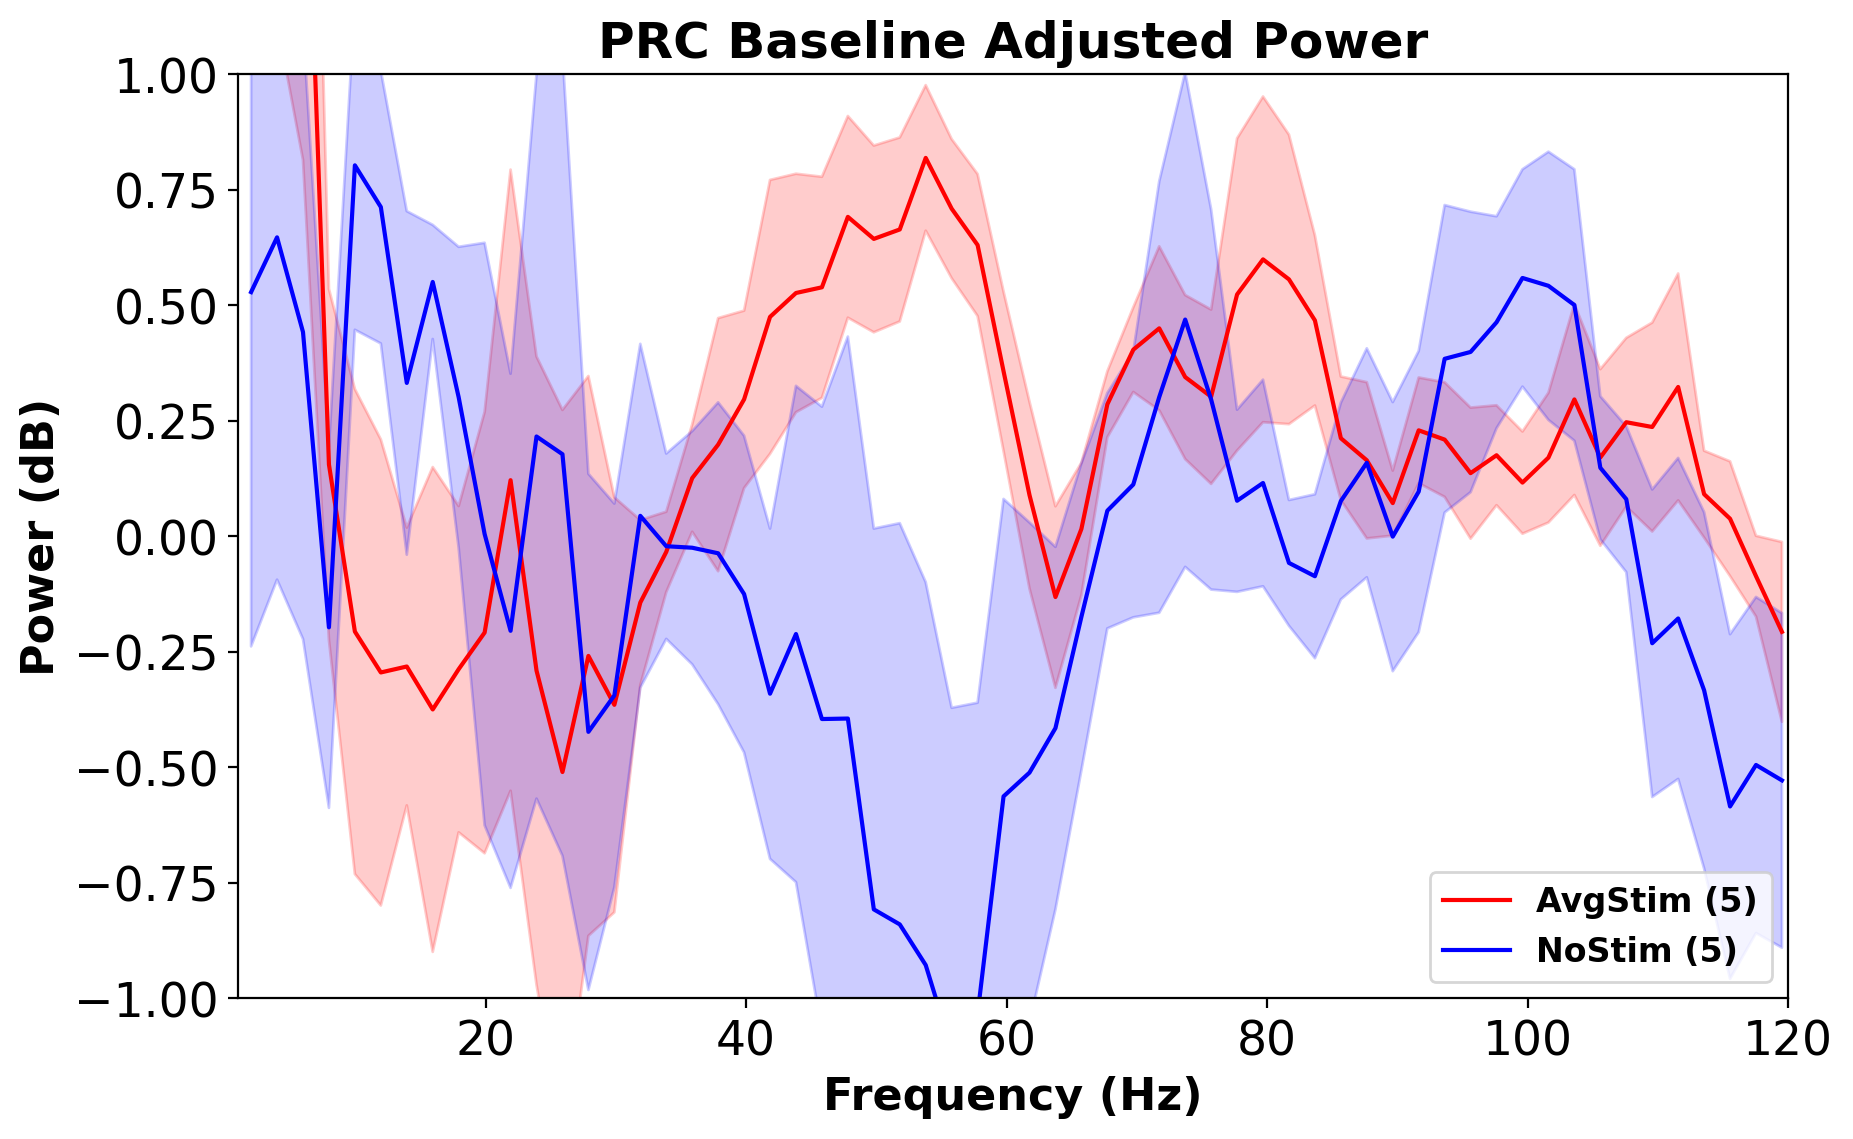

In [12]:
stim_conds_to_plot = {
    'AvgStim': group_avg_power_baseline,
    'NoStim': group_ns_power_baseline,
    #'OneStim': group_onestim_power_baseline,
    #'ThreeStim': group_threestim_power_baseline,
    #'BeforeStim': group_beforestim_power_baseline,
    #'DuringStim': group_duringstim_power_baseline,
    #'AfterStim': group_afterstim_power_baseline,
}

stim_cond_colors = {
    'AvgStim': 'red',
    'NoStim': 'blue',
    #'OneStim': 'green',
    #'ThreeStim': 'orange',
    #'BeforeStim': 'purple',
    #'DuringStim': 'pink',
    #'AfterStim': 'black',
}

for roi in ROIs:    # Create a range for the x-axis
    print(f"Processing ROI: {roi}")
    #x = np.linspace(1, 120, num=len(mean))
    plt.close()
    plt.figure(figsize=(10, 6))

    for stim_cond_name, stim_cond in stim_conds_to_plot.items():
        # Plot the lines
        this_roi_power_data = []
        for subject, power in stim_cond[roi].items():
            this_roi_power_data.append(power)
        this_roi_power_data = np.array(this_roi_power_data)

        num_subjects = len(stim_cond[roi].values())

        # Calculate the mean and standard deviation
        mean = np.mean(this_roi_power_data, axis=0)
        std = np.std(this_roi_power_data, axis=0)
        # Calculate the standard error
        se = std / np.sqrt(num_subjects)

        color = stim_cond_colors[stim_cond_name]
        # Create the plot
        plt.plot(freqs, mean, label=f'{stim_cond_name} ({num_subjects})', color = color)
        plt.fill_between(freqs, mean - se, mean + se, alpha=0.2, color = color, label=None)

    # Add labels and legend
    # Add titles and labels
    plt.title(f'{roi} Baseline Adjusted Power',fontsize=18, fontweight='bold')
    plt.xlabel('Frequency (Hz)',fontsize=16, fontweight='bold')
    plt.ylabel('Power (dB)',fontsize=16, fontweight='bold')
    plt.legend(prop={'weight': 'bold', 'size': 12})
    plt.ylim(-1,1)
    plt.xlim(1,120)

    # Make x ticks, y ticks bold and larger
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    # Show the plot
    plt.savefig(os.path.join(group_results_path, f'{roi}_Baseline_Adjusted_Power.png'))
    plt.show()

Processing ROI: Hipp


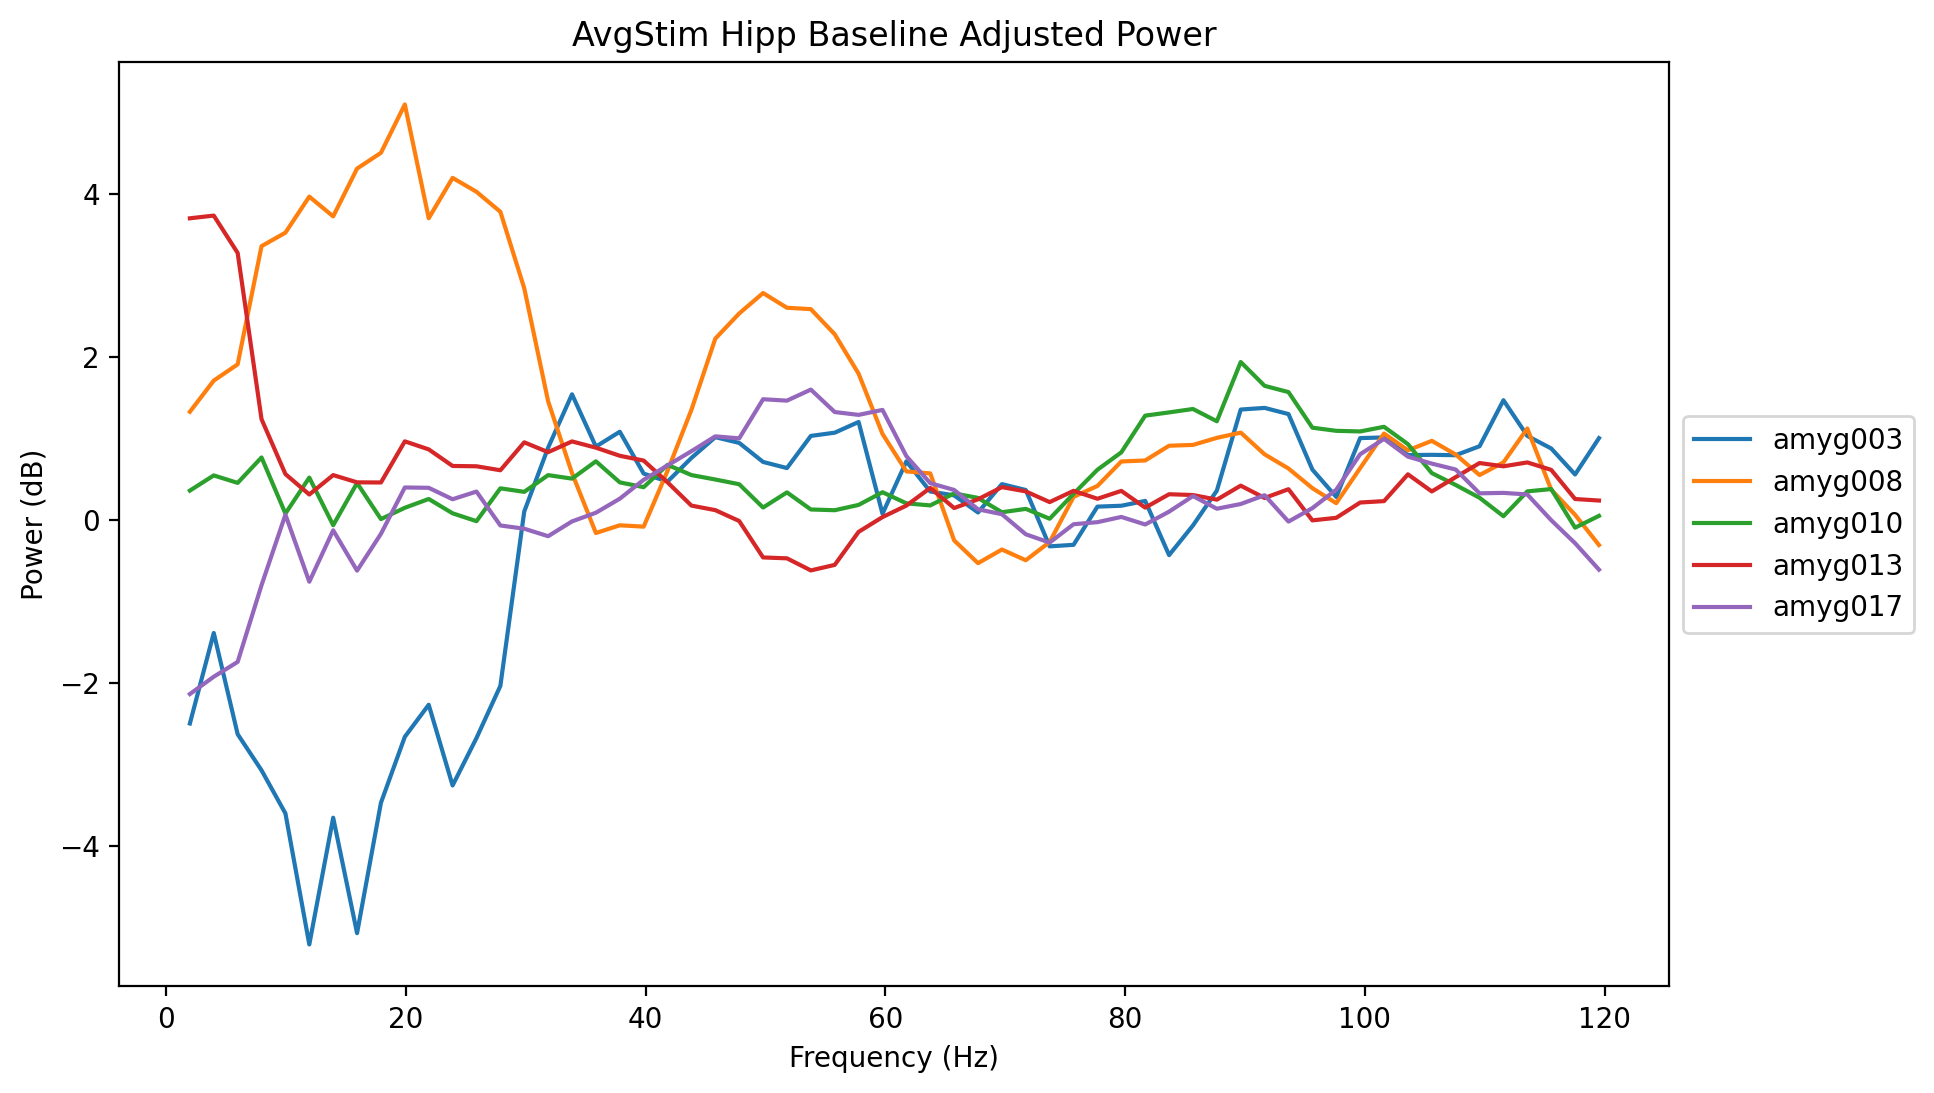

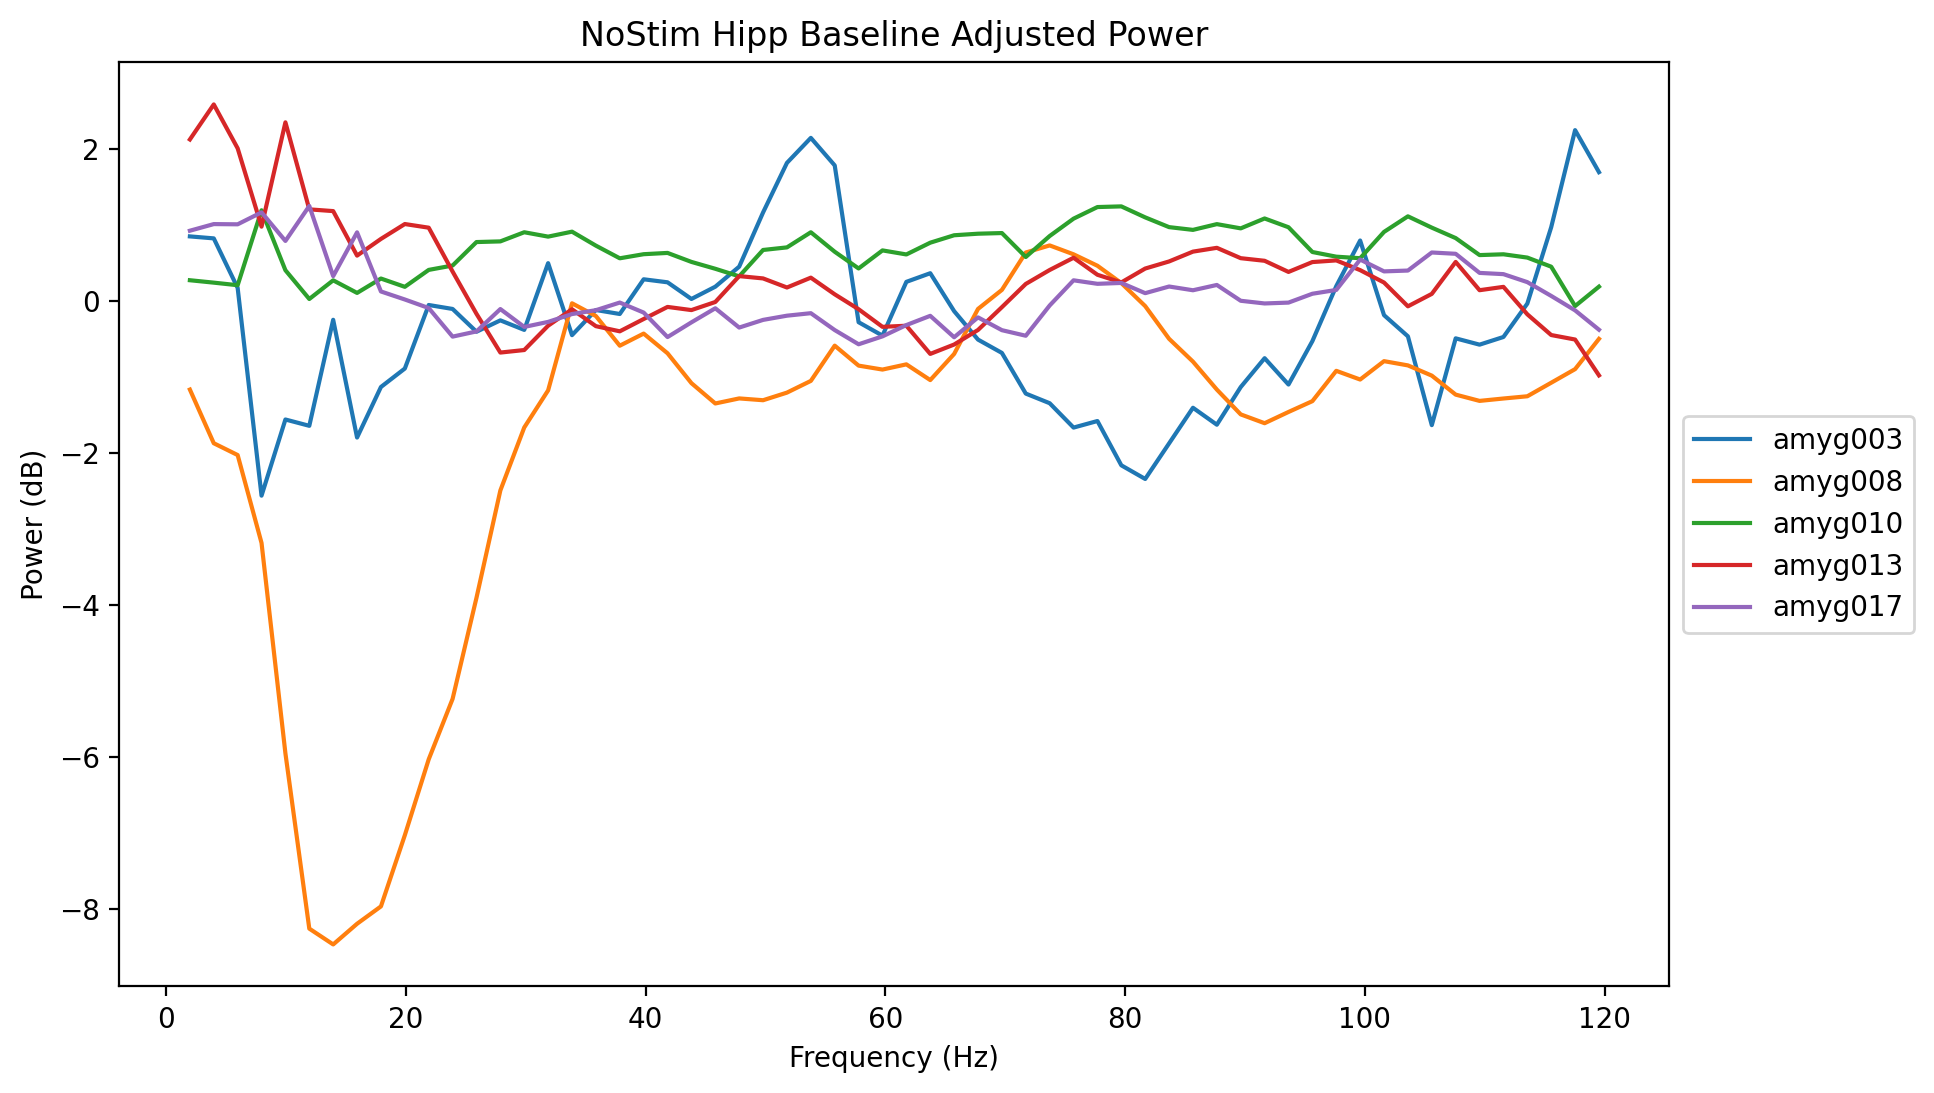

Processing ROI: BLA


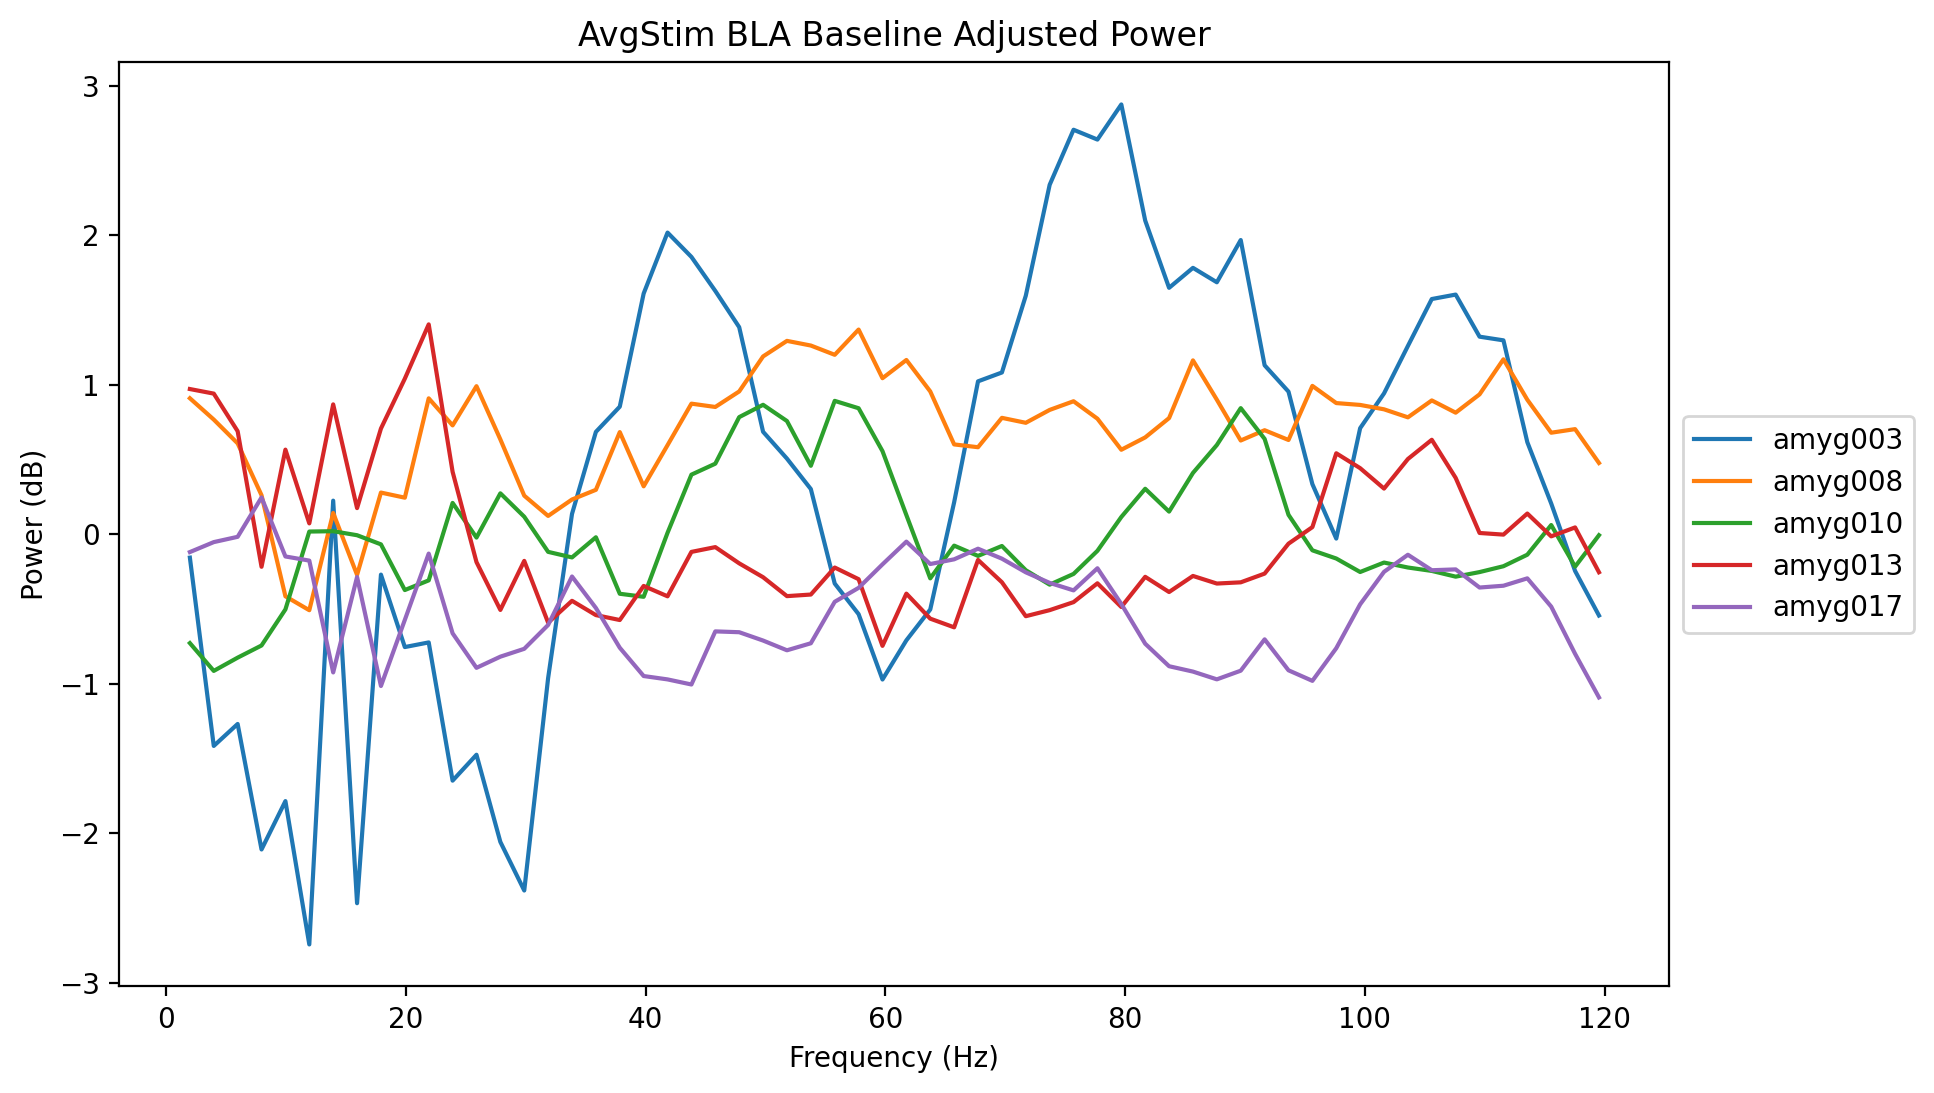

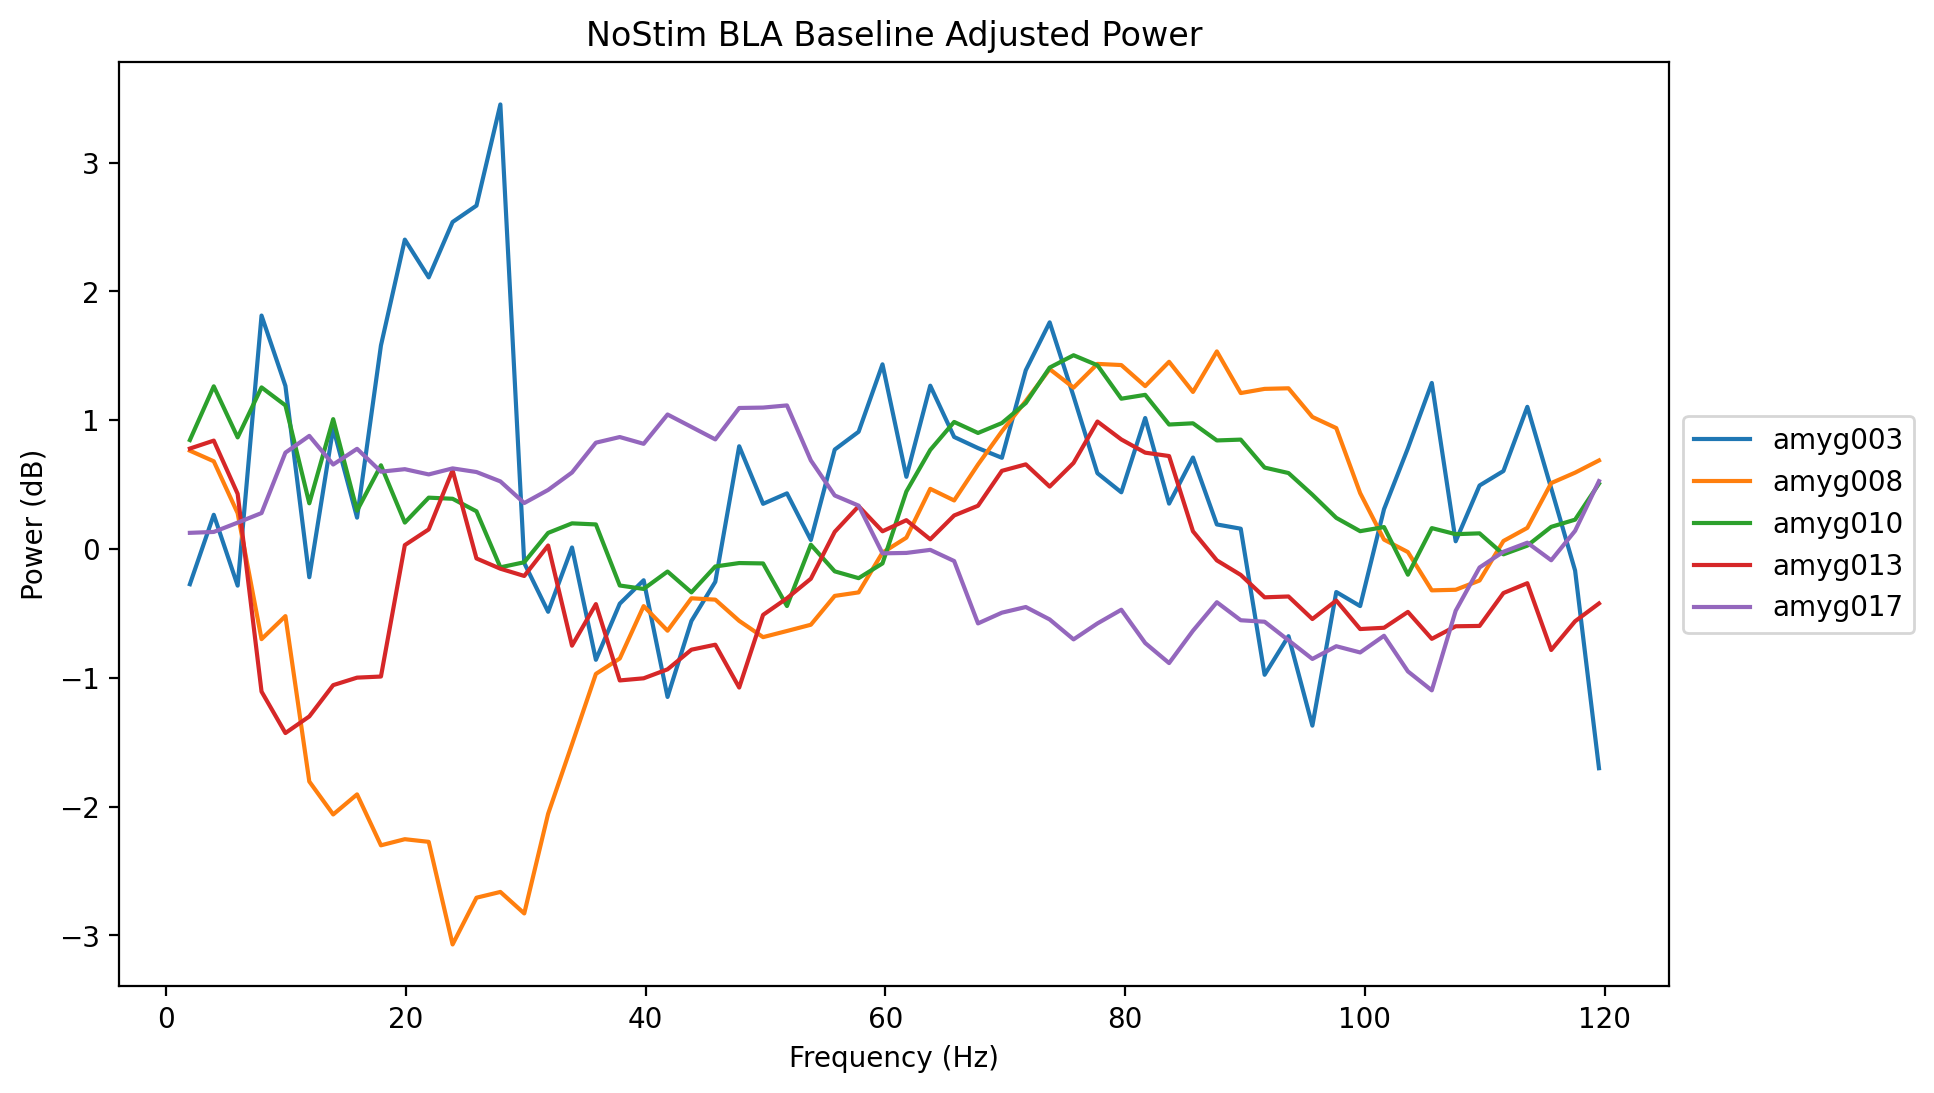

Processing ROI: PRC


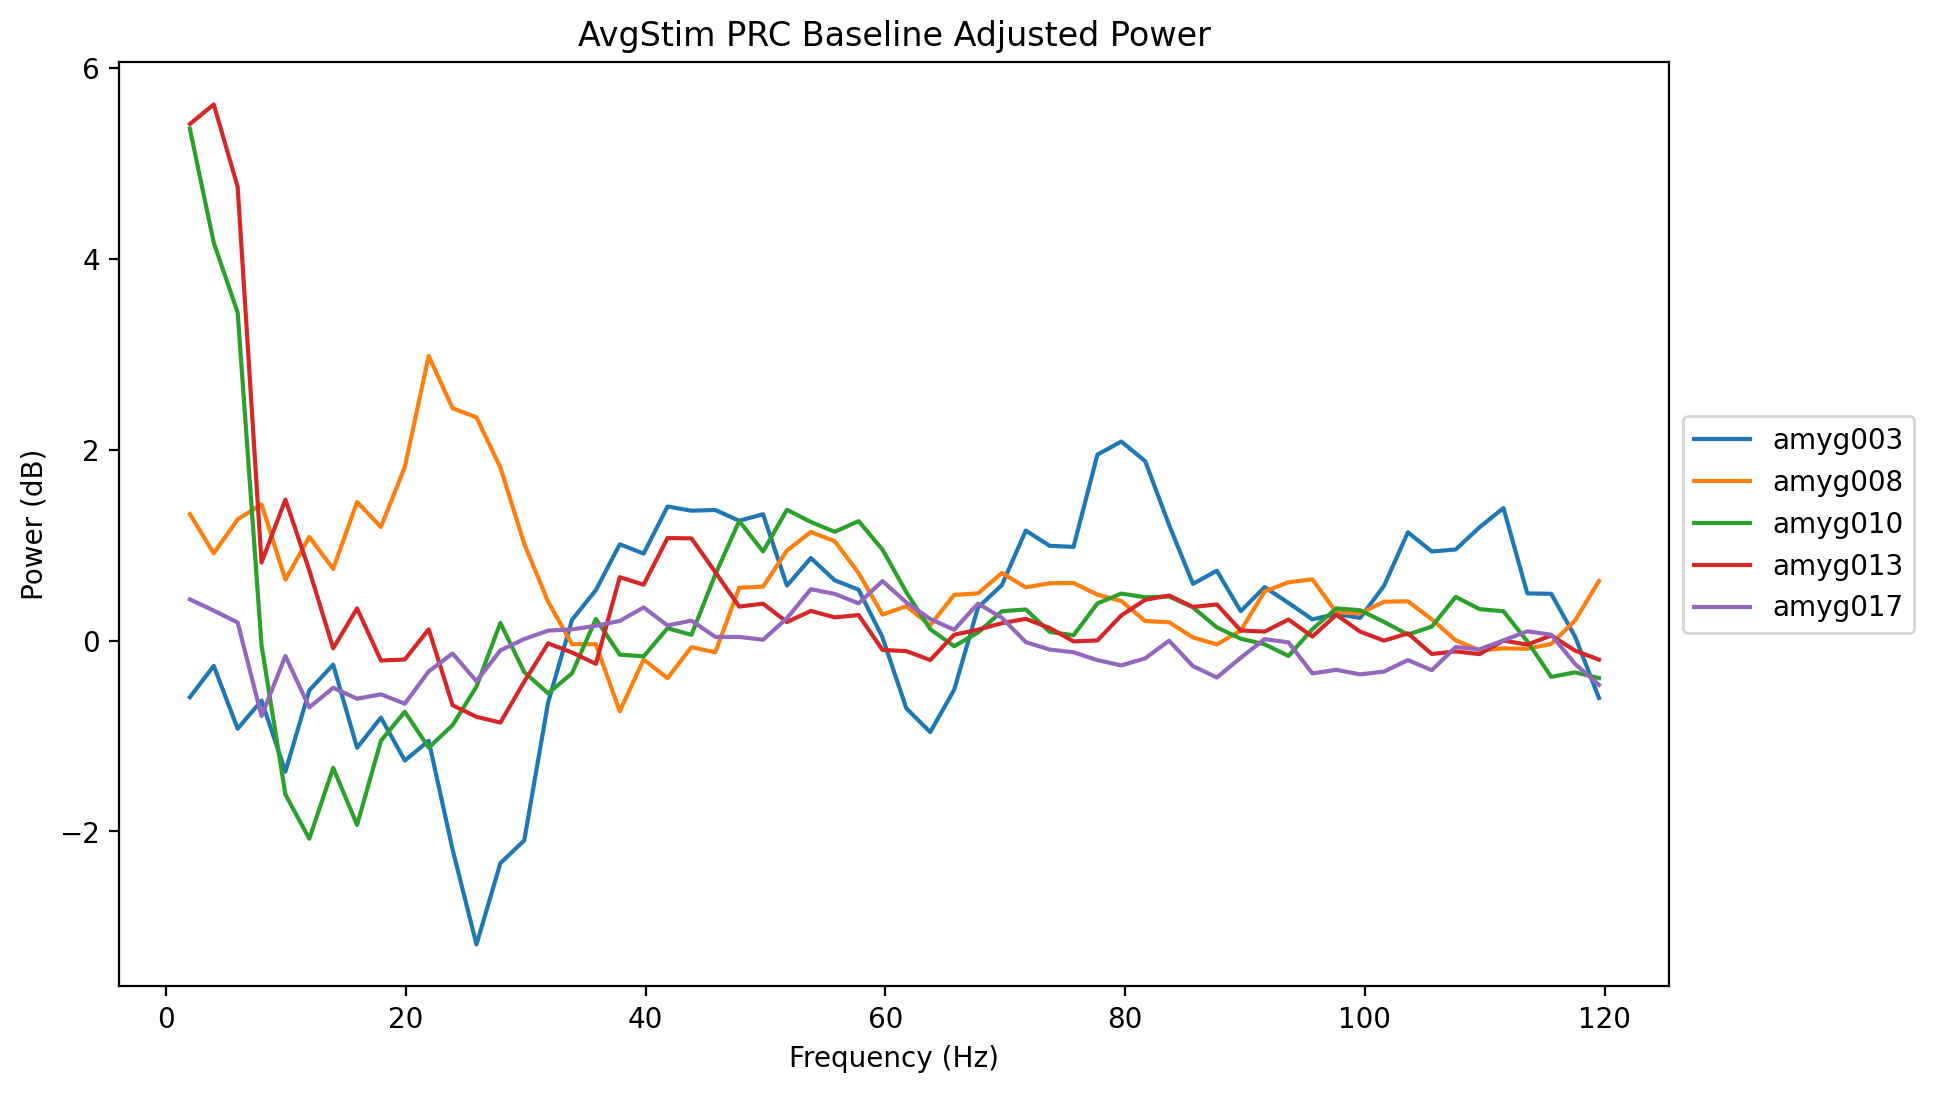

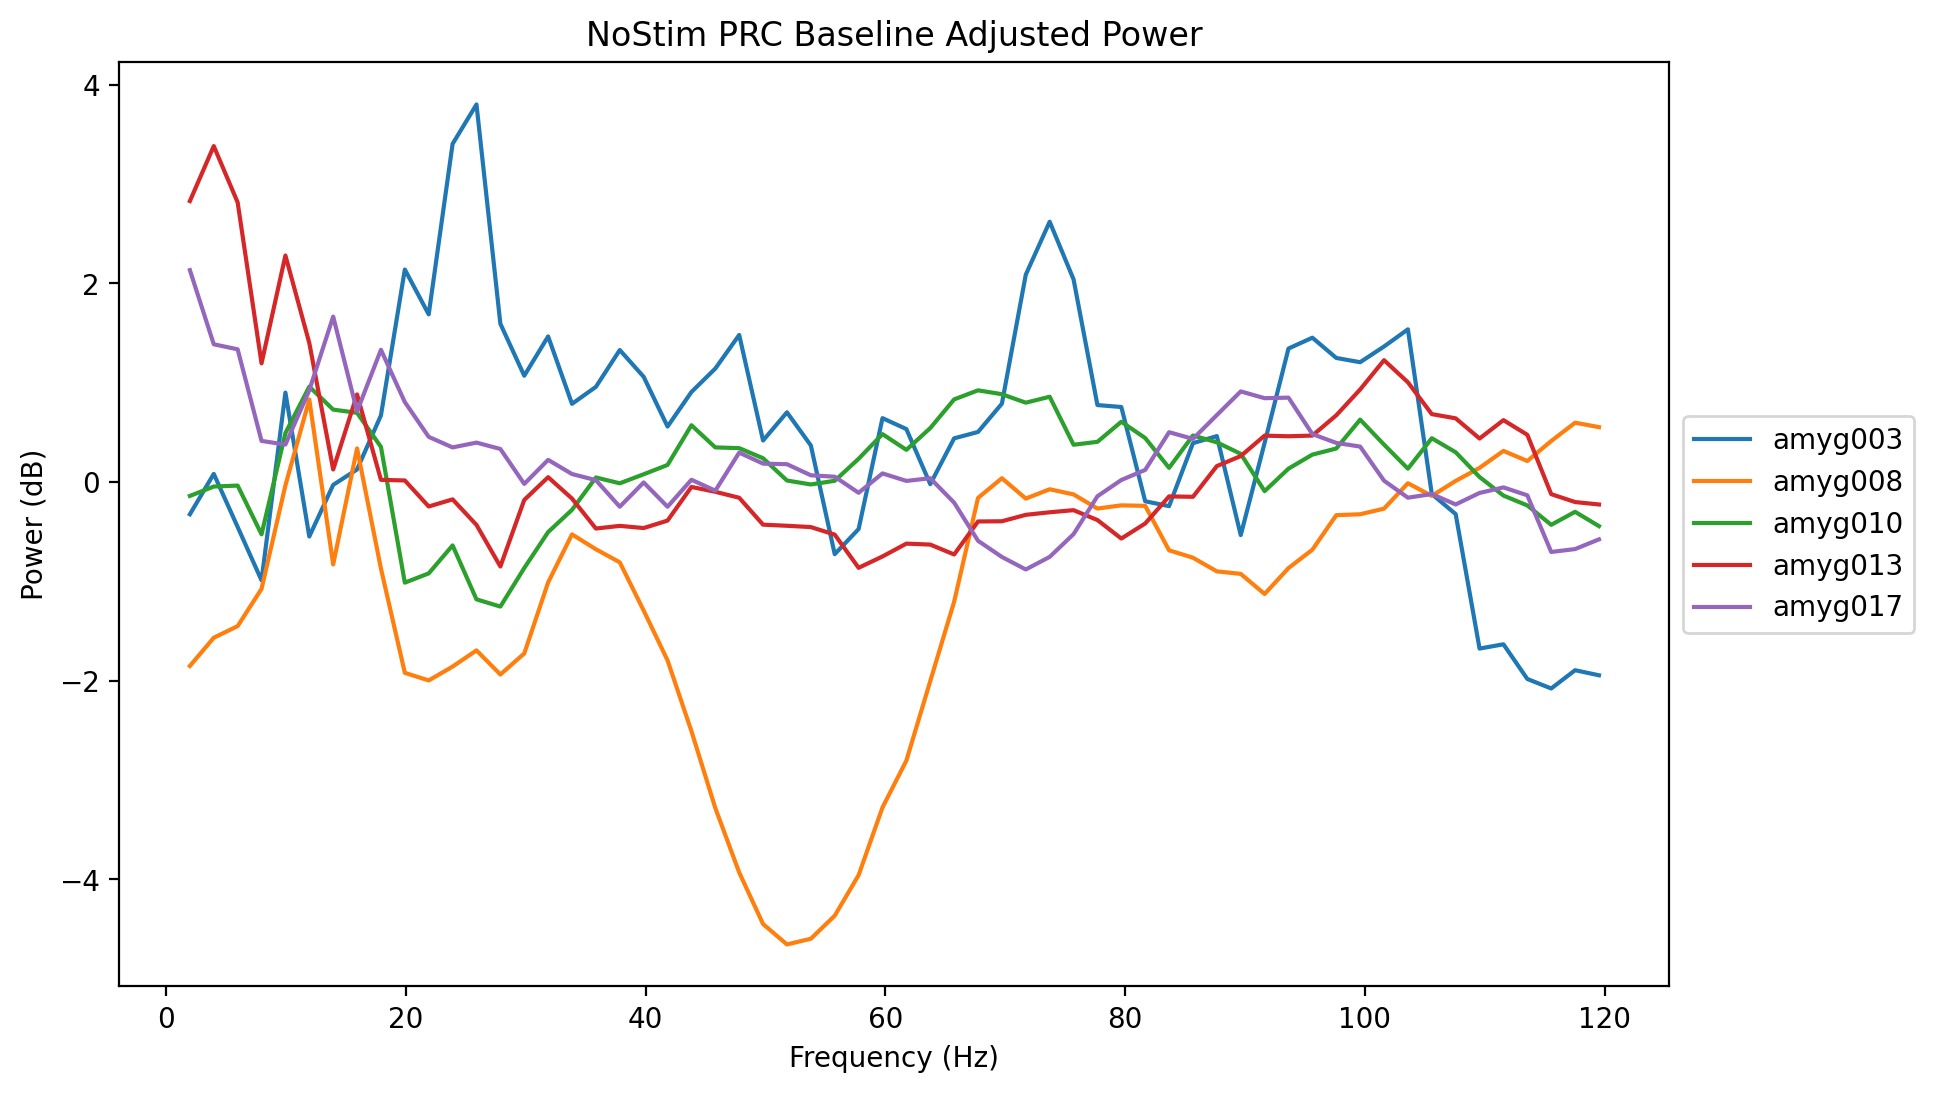

In [13]:
stim_conds_to_plot = {
    'AvgStim': group_avg_power_baseline,
    'NoStim': group_ns_power_baseline,
    #'OneStim': group_onestim_power_baseline,
    #'ThreeStim': group_threestim_power_baseline,
    #'BeforeStim': group_beforestim_power_baseline,
    #'DuringStim': group_duringstim_power_baseline,
    #'AfterStim': group_afterstim_power_baseline,
}

stim_cond_colors = {
    'AvgStim': 'red',
    'NoStim': 'blue',
    #'OneStim': 'green',
    #'ThreeStim': 'orange',
    #'BeforeStim': 'purple',
    #'DuringStim': 'pink',
    #'AfterStim': 'black',
}

for roi in ROIs:    # Create a range for the x-axis
    print(f"Processing ROI: {roi}")
    #x = np.linspace(1, 120, num=len(mean))

    for stim_cond_name, stim_cond in stim_conds_to_plot.items():
        plt.close()
        plt.figure(figsize=(10, 6))
        
        # Plot the lines
        this_roi_power_data = []
        for subject, power in stim_cond[roi].items():
            plt.plot(freqs, power, label=f'{subject}')

        # Create the plot

        # Add labels and legend
        # Add titles and labels
        plt.title(f'{stim_cond_name} {roi} Baseline Adjusted Power')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power (dB)')
        #put legend outside of plot
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # Show the plot
        plt.show()

# OLD STUFF

In [ ]:
# Get the ROI channels for all subjects
all_roi_info = []
all_channel_info = []
all_raw_numpy_data = []
all_events = []

all_raw_np_one_stim = []
all_raw_np_three_stim = []
all_raw_np_no_stim = []

for subject in subjects:
    datapath = os.path.join(project_path, subject)
    preproDataPath = os.path.join(datapath, 'PreprocessedData')

    # Read in ROI channel info
    subj_roi_info = np.load(os.path.join(preproDataPath, 'ROI_channels.npy'))
    all_roi_info.append(subj_roi_info)

    # Read in the subject channel labels
    subj_all_info = list(pd.read_csv(os.path.join(preproDataPath, 'ChanLabels.csv'), index_col=0)['Chan'].values)
    all_channel_info.append(subj_all_info)

    # Read in numpy arrays from each subject and append them to the list
    subj_raw_epoch_data = np.load(os.path.join(preproDataPath, 'PreprocessedData.npy'))
    all_raw_numpy_data.append(subj_raw_epoch_data)

    # Read in event data for this subject
    subj_events = np.load(os.path.join(preproDataPath, 'Events.npy'))
    all_events.append(subj_events)

    all_raw_np_one_stim.append(np.load(os.path.join(preproDataPath, 'OneStimEpoch-500ms.npy')))
    all_raw_np_three_stim.append(np.load(os.path.join(preproDataPath, 'ThreeStimEpoch-500ms.npy')))
    all_raw_np_no_stim.append(np.load(os.path.join(preproDataPath, 'NoStimEpoch-500ms.npy')))


for i, subj in enumerate(subjects):
    print(f" ========= Subject {subj} ========= ")
    print(f"Subject {subj} has roi channels: {all_roi_info[i]} and all channels: {all_channel_info[i]}")
    print(f"Subject {subj} has raw epoch numpy shape: {all_raw_numpy_data[i].shape}")
    print(f"Subject {subj} has events shape: {all_events[i].shape}")
    print(f"Subject {subj} has onestim shape: {all_raw_np_one_stim[i].shape}")


### Read in Master Excel Channel information

In [ ]:
master_excel_channel_info = pd.read_csv(os.path.join(groupdata_path,'ChanLabel_and_BrainRegions.csv'))

### Read in Raw Numpy arrays and create Epoch MNE data structure

In [ ]:
all_raw_epoch = []
all_one_stim = []
all_three_stim = []
all_no_stim = []
all_avg_stim = []

all_raw_stimPSD = []
all_no_stimPSD = []
all_one_stimPSD = []
all_three_stimPSD = []
all_avg_stimPSD = []

ROI_raw_stimPSD = []
ROI_no_stimPSD = []
ROI_one_stimPSD = []
ROI_three_stimPSD = []
ROI_avg_stimPSD = []

for i, subject in enumerate(subjects):
    print(f" ========= Subject {subj} ========= ")

    # Create MNE object for all channels
    info = mne.create_info(ch_names = all_channel_info[i], ch_types = 'seeg', sfreq=500, verbose = 0)

    epochs = mne.EpochsArray(all_raw_numpy_data[i], info, all_events[i])
    all_raw_epoch.append(epochs)
    print(epochs)
'''
    one_stim = mne.EpochsArray(all_raw_np_one_stim[i], info, [event for event in all_events[i] if event[2] == 1])    
    OneStim_power_allchans = one_stim.compute_psd(method = 'multitaper', fmin = 0.1, fmax = 150, tmin = 0, tmax = 0.5)
    all_one_stimPSD.append(OneStim_power_allchans)
    OneStim_power_ROIchans = one_stim.compute_psd(method = 'multitaper', fmin = 0.1, fmax = 150, tmin = 0, tmax = 0.5, picks=selected_hipp_roi[subject])
    ROI_one_stimPSD.append(OneStim_power_ROIchans)
    all_one_stim.append(one_stim)

    three_stim = mne.EpochsArray(all_raw_np_three_stim[i], info, [event for event in all_events[i] if event[2] == 3])
    ThreeStim_power_allchans = three_stim.compute_psd(method = 'multitaper', fmin = 0.1, fmax = 150, tmin = 0, tmax = 0.5)
    all_three_stimPSD.append(ThreeStim_power_allchans)
    ThreeStim_power_ROIchans = three_stim.compute_psd(method = 'multitaper', fmin = 0.1, fmax = 150, tmin = 0, tmax = 0.5, picks=selected_hipp_roi[subject])
    ROI_three_stimPSD.append(ThreeStim_power_ROIchans)
    all_three_stim.append(three_stim)

    no_stim = mne.EpochsArray(all_raw_np_no_stim[i], info, [event for event in all_events[i] if event[2] == 0])
    NS_power_allchans = no_stim.compute_psd(method = 'multitaper', fmin = 0.1, fmax = 150, tmin = 0, tmax = 0.5)
    all_no_stimPSD.append(NS_power_allchans)
    NS_power_ROIchans = no_stim.compute_psd(method = 'multitaper', fmin = 0.1, fmax = 150, tmin = 0, tmax = 0.5, picks=selected_hipp_roi[subject])
    ROI_no_stimPSD.append(NS_power_ROIchans)
    all_no_stim.append(no_stim)

    avg_stim = mne.EpochsArray(all_raw_np_avg_stim[i], info, [event for event in all_events[i] if event[2] == 1])
    AvgStim_power_allchans = avg_stim.compute_psd(method = 'multitaper', fmin = 0.1, fmax = 150, tmin = 0, tmax = 0.5)
    all_avg_stimPSD.append(AvgStim_power_allchans)
    AvgStim_power_ROIchans = avg_stim.compute_psd(method = 'multitaper', fmin = 0.1, fmax = 150, tmin = 0, tmax = 0.5, picks=selected_hipp_roi[subject])
    ROI_avg_stimPSD.append(AvgStim_power_ROIchans)
    all_avg_stim.append(avg_stim)
'''

In [ ]:
### Concatenate all the epochs

all_hipp_raw_epoch = []
all_amyg_raw_epoch = []

for i, subject in enumerate(subjects):
    if selected_amyg_roi[subject] is not None:
        all_amyg_raw_epoch.append(all_raw_epoch[i].copy().pick(selected_amyg_roi[subject]).get_data())
    else:
       pass # go to the next line (continue restarts the same if statement loop)
    if selected_hipp_roi[subject] is not None:
        all_hipp_raw_epoch.append(all_raw_epoch[i].copy().pick(selected_hipp_roi[subject]).get_data())
    else:
        pass

# Concatenate numpy arrays
all_hipp_raw_epoch = np.concatenate(all_hipp_raw_epoch, axis=0)
all_amyg_raw_epoch = np.concatenate(all_amyg_raw_epoch, axis=0)
print(f"Hipp raw epoch.shape: {all_hipp_raw_epoch.shape}")
print(f"Amyg raw epoch.shape: {all_amyg_raw_epoch.shape}")

# Reconstruct epochs
info = mne.create_info(ch_names = ['hipp'], ch_types = 'seeg', sfreq=500, verbose = 0)
all_hipp_epoch = mne.EpochsArray(all_hipp_raw_epoch, info)
all_amyg_epoch = mne.EpochsArray(all_amyg_raw_epoch, info)

all_hipp_psd = all_hipp_epoch.compute_psd(method = 'multitaper', fmin = 0.1, fmax = 150, tmin = 0, tmax = 0.5)
all_amyg_psd = all_amyg_epoch.compute_psd(method = 'multitaper', fmin = 0.1, fmax = 150, tmin = 0, tmax = 0.5)


In [ ]:
# Assuming x_labels is your fixed array of length 200
x_labels = all_hipp_psd.get_data(return_freqs=True)[1]
np.random.seed(0)  # For reproducibility

# Convert data to a NumPy array for easier manipulation
hipp_data = all_hipp_psd.get_data()
hipp_data = np.squeeze(hipp_data, axis=1)
hipp_data = np.log10(hipp_data) # Convert to log scale - do we need to do this?

amyg_data = all_amyg_psd.get_data()
amyg_data = np.squeeze(amyg_data, axis=1)
amyg_data = np.log10(amyg_data)

# Calculate the mean and standard error at each frequency across all subjects
#Hipp
mean_values = np.mean(hipp_data, axis=0)
standard_error = np.std(hipp_data, axis=0, ddof=1) # / np.sqrt(data_array.shape[0])
plt.plot(x_labels, mean_values, label='Hipp', color = 'orange')# Plotting the mean line
plt.fill_between(x_labels, mean_values - standard_error, mean_values + standard_error, color='orange', alpha=0.3)# Plotting the shaded region for standard error

#Amyg
mean_values = np.mean(amyg_data, axis=0)
standard_error = np.std(amyg_data, axis=0, ddof=1) # / np.sqrt(data_array.shape[0])
plt.plot(x_labels, mean_values, label='BLA', color = 'cyan')
plt.fill_between(x_labels, mean_values - standard_error, mean_values + standard_error, color='cyan', alpha=0.3)

# Adding labels and legend
plt.xlim([0, 150])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title('Power Spectrum Density all subjects')
legend_patches = [
    mpatches.Patch(color='cyan', label='Amyg', alpha=.3),
    mpatches.Patch(color='orange', label='Hipp', alpha=.3),
]
plt.legend(handles=legend_patches, loc='upper right')

# Display the plot
plt.savefig(os.path.join(group_results_path, 'PowerSpectra_allsubjects.png'), dpi = 1200, bbox_inches = 'tight')
plt.show()


In [ ]:
# Power Spectral Density Params (PSD)
pad = 0.1

# Figure params
plt.close()
fig, axes = plt.subplots(1,2, figsize = (12,4), sharey = True) #first two numbers represent the matrix of subfigures created, for example, 1,4, will create 4 subfigures in a row

# Create stim/no-stim epochs
NoStimEpoch = mne.io.read_raw_edf(os.path.join(preproDataPath, 'NoStimEpoch-500ms.edf'))
AvgStimEpoch = mne.io.read_raw_edf(os.path.join(preproDataPath, 'AvgStimEpoch-500ms.edf'))

# Compute Stim and No Stim PSDs for all channels
NS_power_allchans = NoStimEpoch.compute_psd(method = 'multitaper', fmin = 0.1, fmax = 150, tmin = 0, tmax = 0.5)
AvgStim_power_allchans = AvgStimEpoch.compute_psd(method = 'multitaper', fmin = 0.1, fmax = 150, tmin = 0, tmax = 0.5)
print(NS_power_allchans)

# Compute Stim and No Stim PSDs for ROI channels
NS_power_ROIchans = NoStimEpoch.compute_psd(method = 'multitaper', fmin = 0.1, fmax = 150, tmin = 0, tmax = 0.5, picks=ROI_channels)
AvgStim_power_ROIchans = AvgStimEpoch.compute_psd(method = 'multitaper', fmin = 0.1, fmax = 150, tmin = 0, tmax = 0.5, picks=ROI_channels)

# Get freqs
_, PSD_freqs = NS_power_allchans.get_data(return_freqs=True)

# Plot PSDs for all channels
NS_power_allchans.plot(axes = axes[0], color = 'blue', average = True)
AvgStim_power_ROIchans.plot(axes = axes[0], color = 'red', average = True)

# Plot PSDs for ROI channels
NS_power_ROIchans.plot(axes = axes[1], color = 'blue', average = True)
AvgStim_power_ROIchans.plot(axes = axes[1], color = 'red', average = True)

# Clean-up Figures
#fig.suptitle('\n (First 500 ms after image onset)')
axes[0].set_title('Power by stim cond for all channels')
axes[1].set_title('Power by stim cond for hipp ROI channels')
#axes[2].set_title('Power by stim cond for EC channels')
#axes[3].set_title('Power by stim cond for PRC channels')
#axes[4].set_title('Power by stim cond for PHG channels')
axes[0].set_ylabel('dB')
axes[1].set_ylabel('dB')
axes[0].set_xlabel('Frequency (Hz)')
axes[1].set_xlabel('Frequency (Hz)')
sns.despine(top = True, right = True)

# Manually create legend with custom colored patches
legend_patches = [
    mpatches.Patch(color='blue', label='No Stim', alpha=.5),
    mpatches.Patch(color='red', label='Avg Stim', alpha=.5)
]
axes[1].legend(handles=legend_patches, loc='upper right')
axes[0].legend().remove()# Remove legend from the first subplot

# Save
#plt.savefig(os.path.join(savepath, 'PowerSpectra-hipp.png'), dpi = 1200, bbox_inches = 'tight')
plt.show()

In [ ]:
# Initialize dataframe
theta_contrastDF = []

# Loop through subjects
for subject in subjects:
    # Define processed data path for the subject
    proc_data_path = os.path.join(project_path, subject, 'PreprocessedData/LFP_analysis_results')
    
    # Find all 'ThetaContrastDF.csv' files in 'Results' subfolders
    proc_data_files = glob.glob(os.path.join(proc_data_path, '**/' + 'theta5-8HzContrastDF.csv'), recursive=True)

    # Load all files into a list and concatenate into one dataframe
    for file in proc_data_files:
        df = pd.read_csv(file, index_col=0)
        df['pID'] = subject
        df = df[df['t Acceptable'] == True]
        theta_contrastDF.append(df)
    
    # Print the subject and the corresponding data
    print(f"Working on subject: {subject}")
    print("--------------------")

# Concatenate all DataFrames into a single DataFrame
if theta_contrastDF:
    theta_contrast = pd.concat(theta_contrastDF, axis=0)
    theta_contrast.insert(4, 'Label', 'Hipp') # add the label 'Hipp' to the 5th column for each row
    
    # Export the combined DataFrame to a CSV file
    theta_contrast.to_csv(os.path.join(group_res_path, 'GroupTheta5-8HzContrast.csv'))

    # Print confirmation
    print("Group contrast data successfully saved.")
else:
    print("No data to save.")

Load and combine the `full_contrast.csv` files generated by `AMME_perSubject_LFP_Analyses.ipynb`.

In [ ]:
# Initialize dataframe
fullPSD_DF = []

# Loop through subjects
for subject in subjects:
    # Define processed data path for the subject
    proc_data_path = os.path.join(project_path, subject, 'PreprocessedData/LFP_analysis_results')

    # find all 'PSDContrastDF.csv' files in 'Results' subfolders
    PSD_data_files = glob.glob(os.path.join(proc_data_path, '**/' + 'full_powercontrast_AvgStimNoStim_roi_hipp.csv'), recursive=True)

    # Load all files into a list and concatenate into one dataframe
    for file in PSD_data_files:
        df = pd.read_csv(file, index_col=0)
        df['pID'] = subject
        df = df[df['t Acceptable'] == True]
        fullPSD_DF.append(df)
        
    
    # Print the subject and the corresponding data
    print(f"Working on subject: {subject}")
    print("--------------------")

# Concatenate all DataFrames into a single DataFrame
if fullPSD_DF:
    full_contrast = pd.concat(fullPSD_DF, axis=0)
    
    # Simplify outcomes
    PSD_res = []
    for i in range(full_contrast.shape[0]):
        if full_contrast.iloc[i]['p'] >= 0.05:
            PSD_res.append('NS')
        elif (full_contrast.iloc[i]['p'] < 0.05) & (full_contrast.iloc[i]['t Stat'] > 0):
            PSD_res.append('Increase')
        elif (full_contrast.iloc[i]['p'] < 0.05) & (full_contrast.iloc[i]['t Stat'] < 0):
            PSD_res.append('Decrease')
    full_contrast['Result'] = PSD_res

    # Reset index
    full_contrast.reset_index(inplace=True, drop=True)
    
    # Export the combined DataFrame to a CSV file
    full_contrast.to_csv(os.path.join(group_res_path, 'GroupFullPSDContrast.csv'))

    # Print confirmation
    print("Group contrast data successfully saved.")
else:
    print("No data to save.")

### 1.1 Isolate Hippocampal Contacts
Use the LeGUI-defined atlas labels to isolate bipolar channel pairs with at least one contact in the hippocampus.

In [ ]:
# Identify the hippocampal contacts
contacts_HIP = theta_contrast[theta_contrast['Label'].str.contains('Hipp')]

# Merge data DFs w/ electrode info
theta_contrast_HIP = pd.merge(contacts_HIP, theta_contrast, on=['pID', 'Chan'])
full_contrast_HIP = pd.merge(contacts_HIP, full_contrast, on=['pID', 'Chan'])
full_contrast_HIP


### 1.3 Isolate MTL Contacts

In [ ]:
MTLLabels = ['Hipp', 'Amyg', 'MTG', 'STG', 'ITG']

# filter group_contrast_elecs['Atlas Label] to rows that contain one of the MTLLabels
contacts_MTL = group_contrast_elecs[group_contrast_elecs['Atlas Label'].isin(MTLLabels)].copy()

# Merge data DFs w/ electrode info
theta_contrast_MTL = pd.merge(contacts_MTL, theta_contrast, on=['pID', 'Chan'])
full_contrast_MTL = pd.merge(contacts_MTL, full_contrast, on=['pID', 'Chan'])

# Sort by SessionRelabeled
theta_contrast_MTL = theta_contrast_MTL.sort_values(by=['SessionRelabeled'], ascending=True)
full_contrast_MTL = full_contrast_MTL.sort_values(by=['SessionRelabeled'], ascending=True)

# Reset index
theta_contrast_MTL.reset_index(inplace = True, drop = True)
full_contrast_MTL.reset_index(inplace = True, drop = True)

### 1.4 Isolate CA1 Contacts

In [ ]:
CA1Dataset = pd.read_csv('/Users/justincampbell/Library/CloudStorage/GoogleDrive-u0815766@gcloud.utah.edu/My Drive/Research Projects/BLAES/Data/BLAES_A2/ElectrodeInfo/BLAES CA1 Localizations.csv')
# CA1Dataset

## 2. Descriptives
Save, as a .txt. file, basic information describing the # sessions, # chans, # robustly modulated chans, etc.

### 2.1 All Contacts

In [ ]:
%%capture cap 
# suppress the output but it's a magic Jupyter command that has to be run separately from 'cap'

# Basic descriptives
n_patients = theta_contrast['pID'].unique().shape[0]
n_chans = theta_contrast.shape[0]
perm_sig_df = theta_contrast[theta_contrast['Perm Sig'] == True]
n_perm_sig = perm_sig_df.shape[0]
n_perm_sig_inc = perm_sig_df[perm_sig_df['t Stat'] > 0].shape[0]
n_perm_sig_dec = perm_sig_df[perm_sig_df['t Stat'] < 0].shape[0]

# Print results
print('Feature: %s' % 'Theta (5-8Hz)')
print('Patients: %s' % n_patients)
print('Channels: %s' % n_chans)
print('Responsive Channels: %s/%s (%.2f%%)' % (n_perm_sig, n_chans,100*n_perm_sig/n_chans))
print('    Increased Power: %s/%s (%.2f%%)' % (n_perm_sig_inc, n_perm_sig, 100*n_perm_sig_inc/n_perm_sig))
print('    Decreased Power: %s/%s (%.2f%%)' % (n_perm_sig_dec, n_perm_sig, 100*n_perm_sig_dec/n_perm_sig))
print('\nAnalyzed: ' + str(datetime.now()))


In [ ]:
# Save descriptives from group analyses to .txt file
with open(os.path.join(group_res_path, 'Theta5-8HzDescriptives.txt'), 'w') as f:
    f.write(str(cap))

### 2.2 Hippocampus Only

In [ ]:
%%capture cap

# Basic descriptives
n_patients = theta_contrast['pID'].unique().shape[0]
n_chans = theta_contrast.shape[0]
perm_sig_df = theta_contrast[theta_contrast['Perm Sig'] == True]
n_perm_sig = perm_sig_df.shape[0]
n_perm_sig_inc = perm_sig_df[perm_sig_df['t Stat'] > 0].shape[0]
n_perm_sig_dec = perm_sig_df[perm_sig_df['t Stat'] < 0].shape[0]

# Print results
print('Feature: %s' % 'Theta (5-8Hz)')
print('Patients: %s' % n_patients)
print('Channels: %s' % n_chans)
print('Responsive Channels: %s/%s (%.2f%%)' % (n_perm_sig, n_chans,100*n_perm_sig/n_chans))
print('    Increased Power: %s/%s (%.2f%%)' % (n_perm_sig_inc, n_perm_sig, 100*n_perm_sig_inc/n_perm_sig))
print('    Decreased Power: %s/%s (%.2f%%)' % (n_perm_sig_dec, n_perm_sig, 100*n_perm_sig_dec/n_perm_sig))
print('\nAnalyzed: ' + str(datetime.now()))

In [ ]:
# Save descriptives from group analyses to .txt file
with open(os.path.join(group_res_path, 'ThetaDescriptives_HIP.txt'), 'w') as f:
    f.write(str(cap))

## 3. Visualizations

### 3.1 Group Full-PSD Contrast
Plot the fraction of robustly modulated electrodes (p < 0.05) within each separately analyzed frequency band (1-150Hz).  
**Note, this analysis is purely exploratory, thus, no FPR-correction has been applied.**

In [ ]:
def plot_group_PSD_contrast(full_contrast, save_str = None):
    '''
    This function plots the results from the full PSD contrast (1-150 Hz) for all patients and sessions.
    
    Parameters:
    -----------
    full_contrast : DataFrame
        DataFrame containing the results of the full PSD contrast (1-150 Hz) for all patients and sessions.
    save_str : str
        String to append to figure filename when saving. If None, figure is not saved.
        
    Returns:
    ----------
    None
    
    '''

    # Figure params
    fig, ax = plt.subplots(1,1, figsize = (5,2))
    color_pal = sns.color_palette('coolwarm', 5)
    PSD_colors = ['#E9E9E9', color_pal[4], color_pal[0]]
    n_PSD_chans = full_contrast.shape[0] / full_contrast['Freq'].unique().shape[0]

    # PSD Contrast Fig
    sns.histplot(data=full_contrast, 
                x='Freq', 
                bins = len(full_contrast['Freq'].unique()), 
                hue='Result', 
                hue_order = ['NS', 'Increase', 'Decrease'], 
                palette = PSD_colors, 
                common_norm = True, 
                linewidth = 0.01, 
                multiple='stack')

    # Clean-up figure appearance
    plt.title('Group Stim PSD Contrast', fontsize = 'medium')
    plt.ylabel('% Electrodes', fontsize = 'medium')
    plt.xlabel('Frequency (Hz)', fontsize = 'medium')
    plt.yticks(ticks = [0, n_PSD_chans/5, 2*n_PSD_chans/5, 3*n_PSD_chans/5, 4*n_PSD_chans/5, n_PSD_chans], labels = ['0', '20', '40', '60', '80', '100'], fontsize = 'x-small')
    plt.xticks(ticks = [5, 30, 60, 90, 130], fontsize = 'x-small')
    plt.xlim(1, 150)
    plt.ylim(0, n_PSD_chans)
    sns.despine(top = True, right = True)

    # Add legend
    plt.legend(labels = [r'$\uparrow$', 'NS', r'$\downarrow$'], loc='upper right', title= u'Δ Power', bbox_to_anchor=(1.2, 1.0), prop={'size': 6})
    leg = ax.get_legend()
    leg.legend_handles[0].set_color(color_pal[4])
    leg.legend_handles[1].set_color('#E9E9E9')
    leg.legend_handles[2].set_color(color_pal[0])

    # Save
    if save_str is not None:
        plt.savefig(os.path.join(group_res_path, 'Figures', save_str + '.png'), dpi = 1500, bbox_inches = 'tight')
    plt.show()

In [ ]:
# Generate fig(s)
plot_group_PSD_contrast(full_contrast, 'GroupFullPSDContrast') # All contacts
plot_group_PSD_contrast(full_contrast_HIP, 'GroupPSDContrast_HIP') # Hippocampus only

### 3.2 Group Band Contrast (Theta)
Plot the result from the comparison of pre-/post- theta (3-8Hz) power within each channel (paired t-test) across all sessions.

In [ ]:
def plot_group_band_contrast_theta(ContrastDF, save_str = None):
    '''
    This function plots the results from the theta band-specific contrast (3-8 Hz) for all patients and sessions.
    
    Parameters:
    -----------
    ContrastDF : DataFrame
        DataFrame containing the results of the theta band-specific contrast (3-8 Hz) for all patients and sessions.
    save_str : str
        String to append to figure filename when saving. If None, figure is not saved.
        
    Returns:
    ----------
    None
    
    '''
    
    # Figure params
    n_patients = len(subjects)
    fig = plt.figure(figsize = ((1.25*n_patients) + 1, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[n_patients, 1.25], wspace = 0.025)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    colormap = cm.coolwarm
    norm = plt.Normalize(-5, 5)
    
    Contrast_Avg = ContrastDF.copy()
    print(Contrast_Avg)

    # One sample t test
    t, p = ttest_1samp(Contrast_Avg['t Stat'], popmean = 0, alternative = 'two-sided')
    df = Contrast_Avg.shape[0] - 1
    if p < 0.001:
        p_res = '$\it{p}$ < 0.001'
    elif p < 0.01:
        p_res = '$\it{p}$ < 0.01'
    elif p < 0.05:
        p_res = '$\it{p}$ < 0.05'
    else:
        p_res = '$\it{p}$ = ' + str(np.round(p,3))    

    # Generate theta contrast figure
    sns.scatterplot(x = ContrastDF['pID'], 
                    y = ContrastDF['t Stat'], 
                    c = ContrastDF['t Stat'], 
                    norm = norm, 
                    cmap = colormap, 
                    edgecolor='black', 
                    linewidth = .25, 
                    ax = ax1, 
                    legend = False)

    # Mimic stripplot jitter
    pts = ax1.collections[0]
    pts.set_offsets(pts.get_offsets() + np.c_[np.random.uniform(-.20, .20, len(ContrastDF)), np.zeros(len(ContrastDF))])
    ax1.margins(x=0.5)

    # Generate average theta contrast figure
    sns.swarmplot(y = Contrast_Avg['t Stat'], c = Contrast_Avg['t Stat'], norm = norm, cmap = colormap, edgecolor='black', size =6, linewidth = .1, ax = ax2, legend = False)

    # Clean-up figure appearance
    plt.suptitle('Group Theta (5-8 Hz) Contrast', fontsize = 'x-large')
    ax1.axhline(y = 0, color = 'grey', linestyle = '--', linewidth = 0.5, zorder = -1)
    ax1.set_ylabel('Paired $\it{t}$-Stat \n (NoStim vs. Stim)', fontsize = 'x-large')
    ax1.set_xlabel('')
    ax1.set_ylim(-5.25, 5.25)
    ax1.set_yticks([-5, -2.5, 0, 2.5, 5], labels = ['-5', '-2.5', '0', '2.5', '5'], fontsize = 'large')
    ax1.tick_params(axis = 'x', labelrotation=45, labelsize = 'large')
    plt.axhline(xmin = .1, xmax = .9, y = Contrast_Avg['t Stat'].median(), color = 'k', lw = 2, linestyle = '-', zorder = -1)
    ax2.axhline(y = 0, color = 'grey', linestyle = '--', linewidth = 0.5, zorder = -1)
    ax2.set_ylim(-5.25, 5.25)
    ax2.set_yticks([-5, -2.5, 0, 2.5, 5], labels = ['', '', '', '', ''])
    ax2.set_xticks([-1, 0, 1], labels = ['', 'Group\nAvg', ''], fontsize = 'large')
    ax2.set_ylabel('')
    ax2.text(x = 0, y = 5, s = '$\it{t}$(%i) = %.2f\n%s' %(df, t, p_res), fontsize = 'medium', horizontalalignment='center')
    sns.despine(top = True, right = True)

    # Save
    if save_str is not None:
        plt.savefig(os.path.join(group_res_path, save_str + '.png'), dpi = 1500, bbox_inches = 'tight')
    plt.show()

In [ ]:
# Generate fig(s)
plot_group_band_contrast_theta(theta_contrast, 'GroupThetaContrast') # All contacts
#plot_group_band_contrast_theta(theta_contrast_HIP, 'GroupThetaContrast_HIP') # Hippocampus only
#plot_group_band_contrast_theta(theta_contrast_MTL, 'GroupThetaContrast_MTL') # All MTL

## ASSFN

In [ ]:
ContrastDF = theta_contrast_HIP.copy()

# Take session average
Contrast_Avg = ContrastDF.copy().groupby(['SessionRelabeled', 'pID']).mean(numeric_only = True)
Contrast_Avg.reset_index(inplace = True)
Contrast_Avg['tStat'] = Contrast_Avg['t Stat']

# Setup an intercept-only LMM using the statsmodels package
lmm = smf.mixedlm("tStat ~ 1", Contrast_Avg, groups=Contrast_Avg["pID"])
lmmf = lmm.fit()
print(lmmf.summary())

# Get values
z = lmmf.tvalues[0]
p = lmmf.pvalues[0]

# get confidence intervals
ci = lmmf.conf_int(alpha = 0.05, cols = None)

# Figure params
fig, ax1 = plt.subplots(1, 1, figsize = (4,5))
colormap = cm.coolwarm
norm = plt.Normalize(-5, 5)

# Generate theta contrast figure
sns.scatterplot(x = Contrast_Avg['pID'], 
                y = Contrast_Avg['t Stat'], 
                c = Contrast_Avg['t Stat'], 
                norm = norm, 
                cmap = colormap, 
                edgecolor='black', 
                linewidth = .5, 
                ax = ax1, 
                legend = False)

# Clean-up figure appearance
ax1.collections[0].set_sizes([80])   
ax1.axhline(y = 0, color = 'grey', linestyle = '--', linewidth = 0.5, zorder = -1)
ax1.set_ylabel('Paired $\it{t}$-Stat \n (Pre vs. Post)', fontsize = 1)
ax1.set_xlabel('')
ax1.set_ylim(-5.25, 5.25)
ax1.set_yticks([-5, -2.5, 0, 2.5, 5], labels = ['-5', '-2.5', '0', '2.5', '5'], fontsize = 'large')
ax1.set_ylabel('Paired $\it{t}$-Stat \n (Pre vs. Post)', fontsize = 'x-large')
ax1.tick_params(axis = 'x', labelrotation=45, labelsize = 'small')
ax1.text(x = 7, y = 4.5, s = '$\it{z}$ = %.2f [%.2f, %.2f]\n$\it{p}$ = %.3f' %(z, ci.loc['Intercept', 0], ci.loc['Intercept', 1], p), fontsize = 'medium', horizontalalignment='center')
sns.despine(top = True, right = True)

# Save
plt.savefig(os.path.join(group_res_path, 'Figures', 'AvgIndividualHIPTheta.png'), dpi = 1500, bbox_inches = 'tight')
plt.show()

In [ ]:
ContrastDF = theta_contrast_HIP.copy()

# Figure params
fig, ax2 = plt.subplots(1, 1, figsize = (2.5,5))
colormap = cm.coolwarm
norm = plt.Normalize(-5, 5)

# Take session average
Contrast_Avg = ContrastDF.copy().groupby(['SessionRelabeled']).mean(numeric_only = True)
Contrast_Avg.reset_index(inplace = True)

# One sample t test
t, p = ttest_1samp(Contrast_Avg['t Stat'], popmean = 0, alternative = 'two-sided')
df = Contrast_Avg.shape[0] - 1

# Generate average theta contrast figure
sns.swarmplot(y = Contrast_Avg['t Stat'], c = Contrast_Avg['t Stat'], norm = norm, cmap = colormap, edgecolor='black', size = 10, linewidth = .5, ax = ax2, legend = False)

# Clean-up figure appearance
ax2.axhline(y = 0, color = 'grey', linestyle = '--', linewidth = 0.5, zorder = -1)
ax2.set_ylim(-5.25, 5.25)
ax2.set_yticks([-5, -2.5, 0, 2.5, 5], labels = ['-5', '-2.5', '0', '2.5', '5'])
ax2.set_xticks([-1, 0, 1], labels = ['', 'Session\nAvg', ''], fontsize = 'large')
ax2.set_ylabel('Paired $\it{t}$-Stat \n (Pre vs. Post)', fontsize = 'x-large')
ax2.text(x = 0, y = 4.5, s = '$\it{t}$(%i) = %.2f\n$\it{p}$ = %.3f' %(df, t, p), fontsize = 'medium', horizontalalignment='center')
sns.despine(top = True, right = True)

# Save
plt.savefig(os.path.join(group_res_path, 'Figures', 'AvgHIPTheta.png'), dpi = 1500, bbox_inches = 'tight')
plt.show()

In [ ]:
# # One sample t test
# t, p = ttest_1samp(Contrast_Avg['t Stat'], popmean = 0, alternative = 'two-sided')
# df = Contrast_Avg.shape[0] - 1
# if p < 0.001:
#     p_res = '$\it{p}$ < 0.001'
# elif p < 0.01:
#     p_res = '$\it{p}$ < 0.01'
# elif p < 0.05:
#     p_res = '$\it{p}$ < 0.05'
# else:
#     p_res = '$\it{p}$ = ' + str(np.round(p,3))    